## Avances Laboratorio #3 
##### Data Science  -  Universidad del Valle de Guatemala

- Gustavo Andres Gonzalez Pineda 21438
- Maria Marta Ramirez Gil 21342

--------------------------------------------------------------------------------------- 

Importamos las librerías necesarias para manipulación de datos, visualización, y creación de modelos LSTM.

In [21]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

#Tensorflow
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential,save_model,load_model
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.metrics import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import keras

# Configuración inicial para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

# Cargar los datos
consumo = pd.read_csv('data/CONSUMO.csv')
importacion = pd.read_csv('data/IMPORTACION.csv')
precios = pd.read_csv('data/PRECIOS.csv')

# Mostrar una vista previa de los datos
print("CONSUMO")
display(consumo)
print()
print ("--------------------------------------------------------")
print("IMPORTACION")
display(importacion)
print()
print ("--------------------------------------------------------")
print("PRECIOS")
display(precios)

CONSUMO


,Fecha,GasLicuado,Regular,Superior,Diesel,GasLicuado_log,GasLicuado_diff,Diesel_log,Diesel_diff,Regular_log,Regular_diff,Superior_log,Superior_diff
0,2000-01-01,194410.48,202645.20,308156.82,634667.06,12.177727,NaN,13.360856,NaN,12.219212,NaN,12.638364,NaN
1,2000-02-01,174710.55,205530.96,307766.31,642380.66,12.070886,-0.106841,13.372936,0.012081,12.233352,0.014140,12.637096,-0.001268
2,2000-03-01,189234.07,229499.56,331910.29,699807.25,12.150740,0.079854,13.458560,0.085624,12.343656,0.110304,12.712620,0.075524
3,2000-04-01,174330.61,210680.40,315648.08,586803.98,12.068709,-0.082031,13.282446,-0.176114,12.258098,-0.085559,12.662383,-0.050237
4,2000-05-01,191745.15,208164.34,319667.97,656948.20,12.163922,0.095214,13.395360,0.112914,12.246083,-0.012014,12.675038,0.012655
...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,2024-01-01,548124.45,830708.13,658083.66,1371766.15,13.214258,0.012597,14.131610,0.019500,13.630034,-0.057908,13.397087,-0.049371
289,2024-02-01,526897.85,818740.16,654059.60,1352602.93,13.174762,-0.039496,14.117541,-0.014068,13.615522,-0.014512,13.390954,-0.006134
290,2024-03-01,523990.91,870771.70,671997.05,1405703.42,13.169230,-0.005532,14.156048,0.038507,13.677135,0.061613,13.418009,0.027055
291,2024-04-01,531880.19,847353.15,633520.57,1442103.60,13.184174,0.014944,14.181613,0.025565,13.649873,-0.027262,13.359048,-0.058961



--------------------------------------------------------
IMPORTACION


,Fecha,GasLicuado,Regular,Superior,Diesel,GasLicuado_log,GasLicuado_diff,Diesel_log,Diesel_diff,Regular_log,Regular_diff
0,2001-01-01,194065.74,177776.50,373963.96,566101.99,12.175952,NaN,13.246530,NaN,12.088282,NaN
1,2001-02-01,170703.38,123115.99,243091.07,489525.80,12.047683,-0.128270,13.101192,-0.145337,11.720882,-0.367400
2,2001-03-01,161837.37,161726.42,312084.38,575559.68,11.994347,-0.053335,13.263098,0.161906,11.993661,0.272779
3,2001-04-01,163048.64,127338.74,285054.89,437745.42,12.001804,0.007457,12.989393,-0.273705,11.754606,-0.239055
4,2001-05-01,171518.86,168730.19,300913.67,552609.13,12.052449,0.050645,13.222406,0.233013,12.036056,0.281450
...,...,...,...,...,...,...,...,...,...,...,...
276,2024-01-01,701570.80,914133.32,712333.33,1415808.13,13.461077,0.013473,14.163211,-0.079257,13.725732,0.179730
277,2024-02-01,916541.70,740662.25,650360.11,1241501.08,13.728363,0.267286,14.031832,-0.131379,13.515300,-0.210432
278,2024-03-01,675157.48,838270.93,620077.74,1482045.48,13.422701,-0.305662,14.208934,0.177102,13.639097,0.123797
279,2024-04-01,473940.66,886132.77,687017.96,1294706.12,13.068837,-0.353864,14.073794,-0.135139,13.694622,0.055525



--------------------------------------------------------
PRECIOS


,Fecha,Superior,Regular,Diesel,GasLicuado,Diesel_log,Diesel_diff
0,2021-01-01,21.91,21.11,17.61,99.00,2.868467,NaN
1,2021-02-01,23.57,22.77,18.57,116.00,2.921547,0.053080
2,2021-03-01,25.85,25.05,20.86,116.00,3.037833,0.116286
3,2021-04-01,26.35,25.56,20.80,120.00,3.034953,-0.002880
4,2021-05-01,27.27,26.49,20.87,120.00,3.038313,0.003360
5,2021-06-01,28.01,27.22,22.29,120.00,3.104138,0.065825
6,2021-07-01,27.60,26.80,21.81,120.00,3.082369,-0.021770
7,2021-08-01,28.09,27.29,22.10,120.00,3.095578,0.013209
8,2021-09-01,28.79,27.99,22.79,120.00,3.126322,0.030744
9,2021-10-01,29.29,28.59,23.79,132.00,3.169265,0.042943


Vamos a limpiar las variables que no son estacionarias y reemplazarlas con sus respectivas variables estacionarias. Esto para obtener dataframes limpios.

In [14]:
# CONSUMO.csv
# botar las columnas GasLicuado, Diesel, Regular, Superior, GasLicuado_log, Diesel_log, Regular_log, Superior_log
consumo = consumo.drop(columns=['GasLicuado', 'Diesel', 'Regular', 'Superior', 'GasLicuado_log', 'Diesel_log', 'Regular_log', 'Superior_log'])
# renombrar las columnas
consumo = consumo.rename(columns={'GasLicuado_diff': 'GasLicuado', 'Diesel_diff': 'Diesel', 'Regular_diff': 'Regular', 'Superior_diff': 'Superior'})
print("CONSUMO")
display(consumo)
print()
print ("--------------------------------------------------------")

# IMPORTACION.csv
# botar las columnas GasLicuado_log, GasLicuado, Diesel_log, Diesel, Regular_log, Regular
importacion = importacion.drop(columns=['GasLicuado_log', 'GasLicuado', 'Diesel_log', 'Diesel', 'Regular_log', 'Regular'])
# renombrar las columnas
importacion = importacion.rename(columns={'GasLicuado_diff': 'GasLicuado', 'Diesel_diff': 'Diesel', 'Regular_diff': 'Regular'})
print("IMPORTACION")
display(importacion)
print()
print ("--------------------------------------------------------")

# PRECIOS.csv
# botar las columnas Diesel_log, Diesel
precios = precios.drop(columns=['Diesel_log', 'Diesel'])
# renombrar las columnas
precios = precios.rename(columns={'Diesel_diff': 'Diesel'})
print("PRECIOS")
display(precios)

CONSUMO


,Fecha,GasLicuado,Diesel,Regular,Superior
0,2000-01-01,NaN,NaN,NaN,NaN
1,2000-02-01,-0.106841,0.012081,0.014140,-0.001268
2,2000-03-01,0.079854,0.085624,0.110304,0.075524
3,2000-04-01,-0.082031,-0.176114,-0.085559,-0.050237
4,2000-05-01,0.095214,0.112914,-0.012014,0.012655
...,...,...,...,...,...
288,2024-01-01,0.012597,0.019500,-0.057908,-0.049371
289,2024-02-01,-0.039496,-0.014068,-0.014512,-0.006134
290,2024-03-01,-0.005532,0.038507,0.061613,0.027055
291,2024-04-01,0.014944,0.025565,-0.027262,-0.058961



--------------------------------------------------------
IMPORTACION


,Fecha,Superior,GasLicuado,Diesel,Regular
0,2001-01-01,373963.96,NaN,NaN,NaN
1,2001-02-01,243091.07,-0.128270,-0.145337,-0.367400
2,2001-03-01,312084.38,-0.053335,0.161906,0.272779
3,2001-04-01,285054.89,0.007457,-0.273705,-0.239055
4,2001-05-01,300913.67,0.050645,0.233013,0.281450
...,...,...,...,...,...
276,2024-01-01,712333.33,0.013473,-0.079257,0.179730
277,2024-02-01,650360.11,0.267286,-0.131379,-0.210432
278,2024-03-01,620077.74,-0.305662,0.177102,0.123797
279,2024-04-01,687017.96,-0.353864,-0.135139,0.055525



--------------------------------------------------------
PRECIOS


,Fecha,Superior,Regular,GasLicuado,Diesel
0,2021-01-01,21.91,21.11,99.00,NaN
1,2021-02-01,23.57,22.77,116.00,0.053080
2,2021-03-01,25.85,25.05,116.00,0.116286
3,2021-04-01,26.35,25.56,120.00,-0.002880
4,2021-05-01,27.27,26.49,120.00,0.003360
5,2021-06-01,28.01,27.22,120.00,0.065825
6,2021-07-01,27.60,26.80,120.00,-0.021770
7,2021-08-01,28.09,27.29,120.00,0.013209
8,2021-09-01,28.79,27.99,120.00,0.030744
9,2021-10-01,29.29,28.59,132.00,0.042943


### Manejo de valores faltantes

In [15]:
# Manejo de valores faltantes
# CONSUMO.csv
# Reemplazar los valores faltantes con el promedio de la columna para las columnas GasLicuado, Diesel, Regular, Superior
consumo['GasLicuado'] = consumo['GasLicuado'].fillna(consumo['GasLicuado'].mean())
consumo['Diesel'] = consumo['Diesel'].fillna(consumo['Diesel'].mean())
consumo['Regular'] = consumo['Regular'].fillna(consumo['Regular'].mean())
consumo['Superior'] = consumo['Superior'].fillna(consumo['Superior'].mean())

# IMPORTACION.csv
importacion['GasLicuado'] = importacion['GasLicuado'].fillna(importacion['GasLicuado'].mean())
importacion['Diesel'] = importacion['Diesel'].fillna(importacion['Diesel'].mean())
importacion['Regular'] = importacion['Regular'].fillna(importacion['Regular'].mean())
importacion['Superior'] = importacion['Superior'].fillna(importacion['Superior'].mean())

# PRECIOS.csv
precios['GasLicuado'] = precios['GasLicuado'].fillna(precios['GasLicuado'].mean())
precios['Diesel'] = precios['Diesel'].fillna(precios['Diesel'].mean())
precios['Regular'] = precios['Regular'].fillna(precios['Regular'].mean())
precios['Superior'] = precios['Superior'].fillna(precios['Superior'].mean())


# Verificar si hay valores faltantes
print("CONSUMO")
print(consumo.isnull().sum())
print()
print ("--------------------------------------------------------")
print("IMPORTACION")
print(importacion.isnull().sum())
print()
print ("--------------------------------------------------------")  
print("PRECIOS")
print(precios.isnull().sum()) 

CONSUMO
Fecha         0
GasLicuado    0
Diesel        0
Regular       0
Superior      0
dtype: int64

--------------------------------------------------------
IMPORTACION
Fecha         0
Superior      0
GasLicuado    0
Diesel        0
Regular       0
dtype: int64

--------------------------------------------------------
PRECIOS
Fecha         0
Superior      0
Regular       0
GasLicuado    0
Diesel        0
dtype: int64


## Visualizacion de las series
Usar las variables ya estacionarias

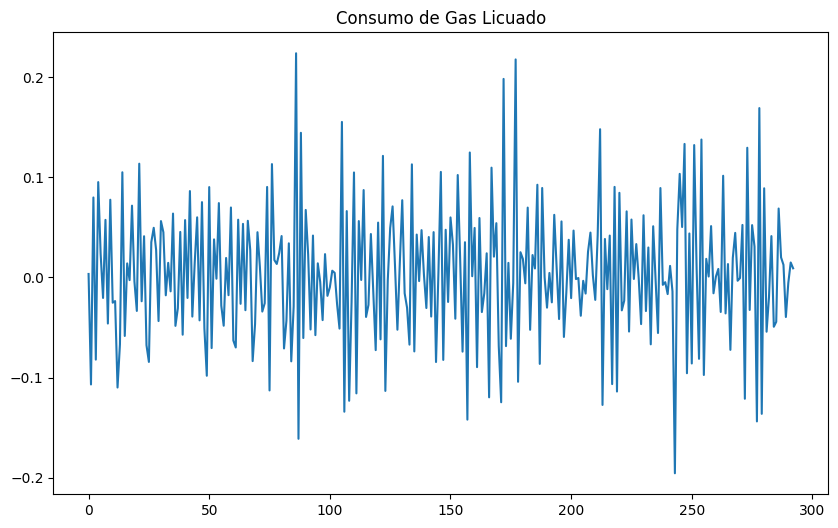

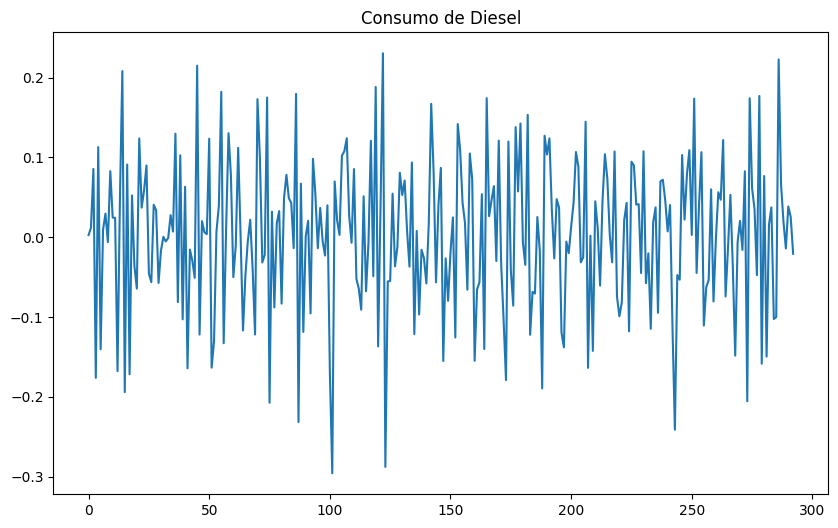

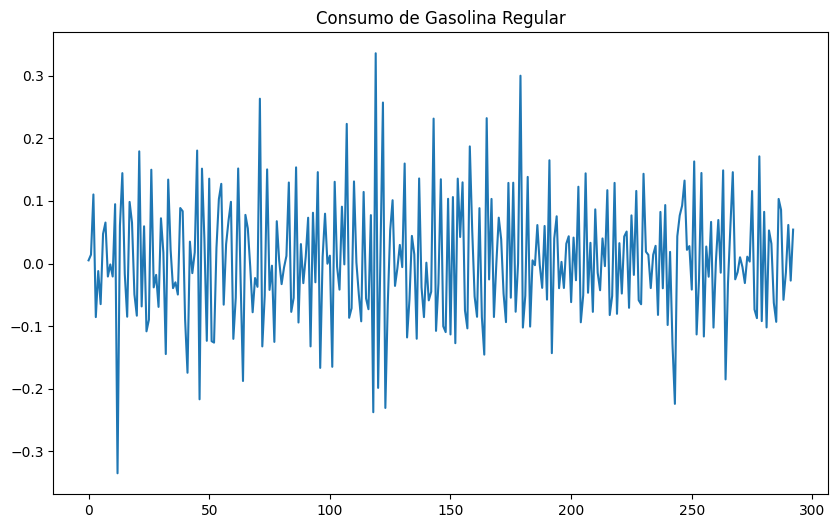

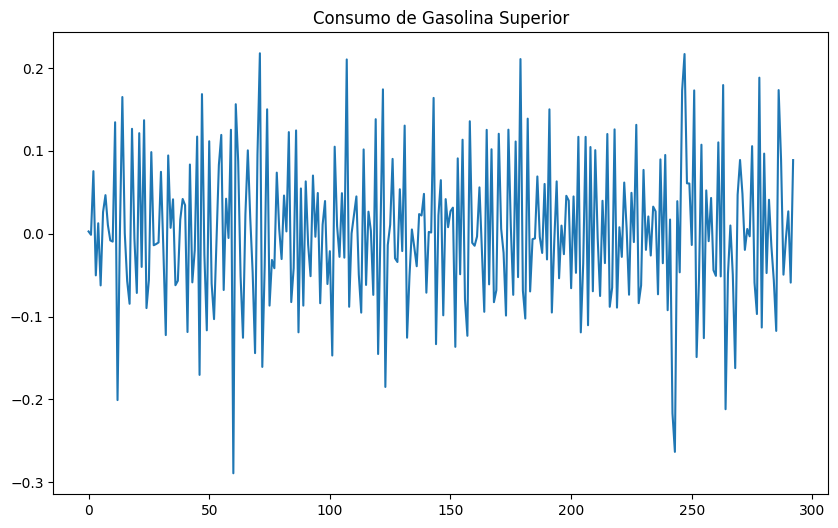

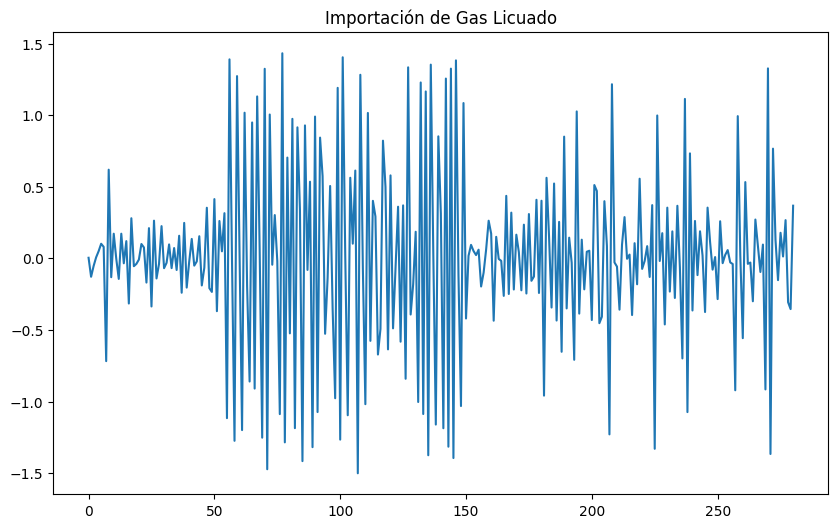

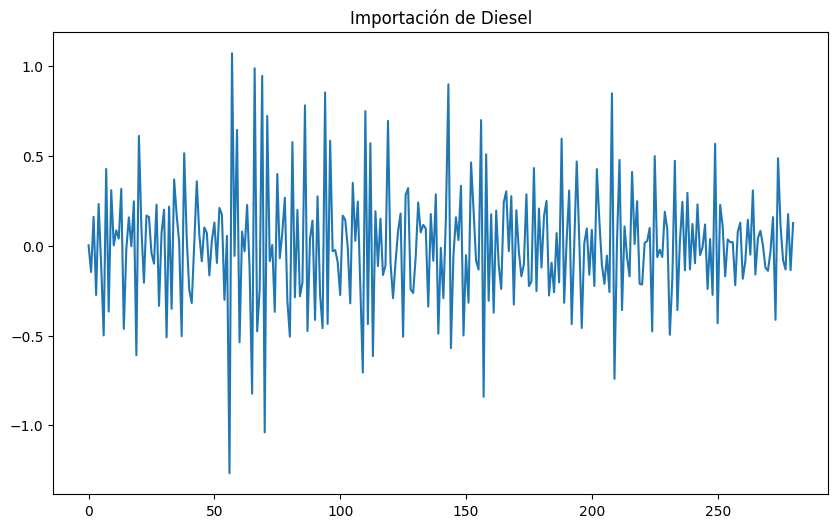

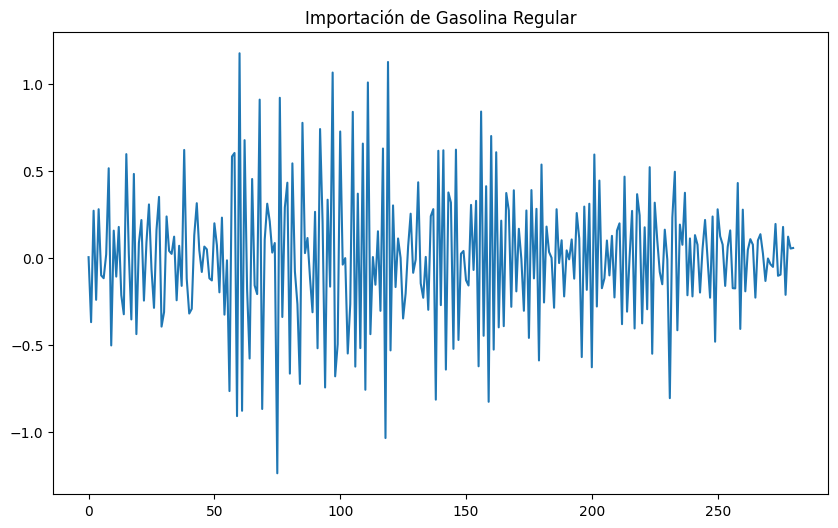

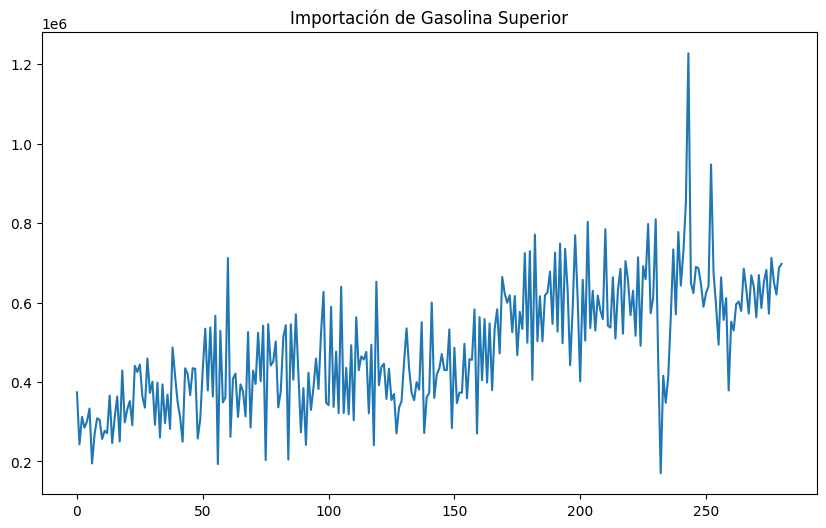

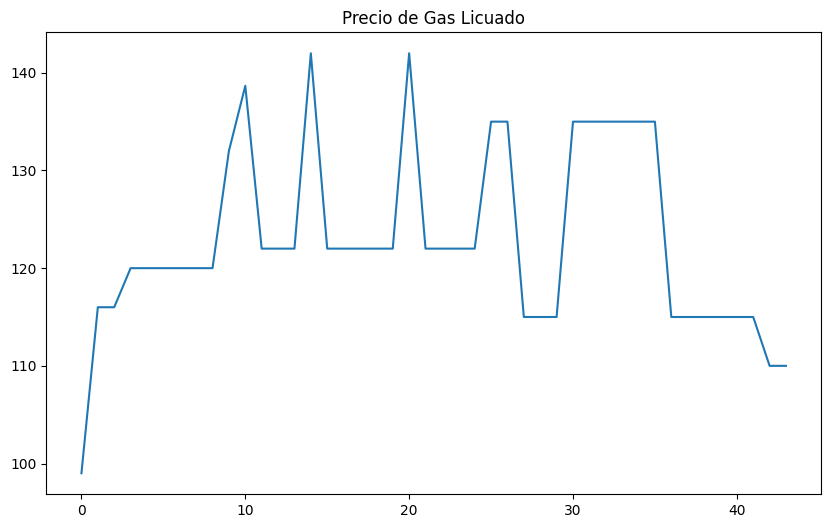

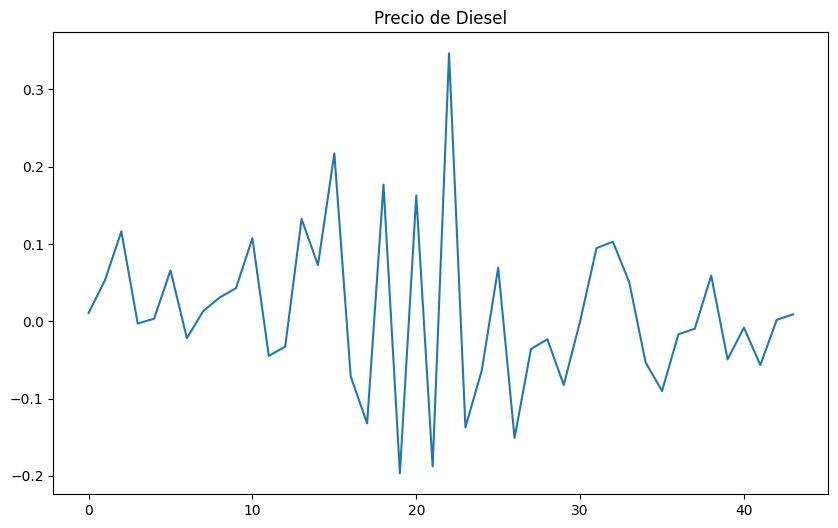

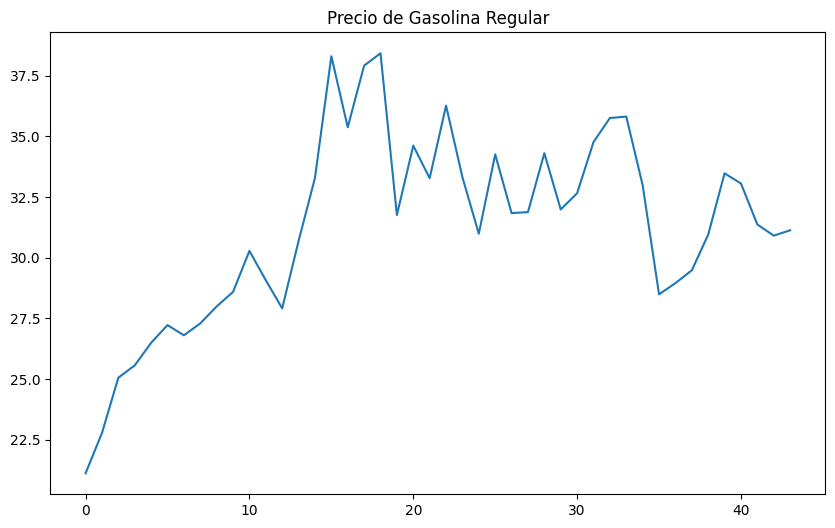

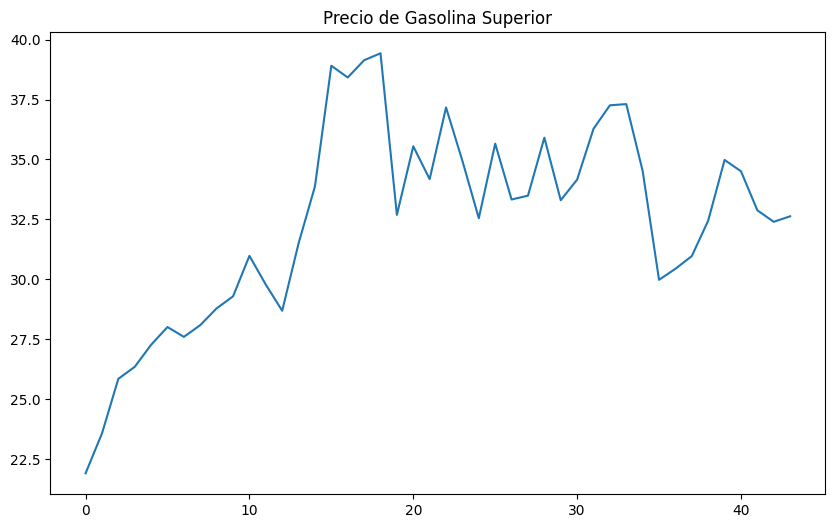

In [16]:
def plot_series(data, title):
    plt.figure(figsize=(10, 6))
    plt.plot(data)
    plt.title(title)
    plt.show()

plot_series(consumo['GasLicuado'], 'Consumo de Gas Licuado')
plot_series(consumo['Diesel'], 'Consumo de Diesel')
plot_series(consumo['Regular'], 'Consumo de Gasolina Regular')
plot_series(consumo['Superior'], 'Consumo de Gasolina Superior')

plot_series(importacion['GasLicuado'], 'Importación de Gas Licuado')
plot_series(importacion['Diesel'], 'Importación de Diesel')
plot_series(importacion['Regular'], 'Importación de Gasolina Regular')
plot_series(importacion['Superior'], 'Importación de Gasolina Superior')

plot_series(precios['GasLicuado'], 'Precio de Gas Licuado')
plot_series(precios['Diesel'], 'Precio de Diesel')
plot_series(precios['Regular'], 'Precio de Gasolina Regular')
plot_series(precios['Superior'], 'Precio de Gasolina Superior')

## Procesamiento de Datos
Para trabajar con modelos LSTM, es necesario escalar los datos. Usamos StandardScaler para normalizar las series de tiempo.

In [9]:
scaler = StandardScaler()

# Escalar solo los datos numéricos
consumo_scaled = scaler.fit_transform(consumo[['GasLicuado', 'Diesel', 'Regular', 'Superior']])
importacion_scaled = scaler.fit_transform(importacion[['GasLicuado', 'Diesel', 'Regular', 'Superior']])
precios_scaled = scaler.fit_transform(precios[['GasLicuado', 'Diesel', 'Regular', 'Superior']])

### Secuencia de datos
Definimos una función para convertir las series de tiempo en secuencias de datos que serán usadas como entrada para el modelo LSTM.

In [10]:
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(x), np.array(y)

seq_length = 12  # Definimos una ventana de tiempo de 12 meses (1 año)

X_consumo_gas_licuado, y_consumo_gas_licuado = create_sequences(consumo_scaled[:, 0], seq_length)
X_importacion_gas_licuado, y_importacion_gas_licuado = create_sequences(importacion_scaled[:, 0], seq_length)
X_precios_gas_licuado, y_precios_gas_licuado = create_sequences(precios_scaled[:, 0], seq_length)

X_consumo_diesel, y_consumo_diesel = create_sequences(consumo_scaled[:, 1], seq_length)
X_importacion_diesel, y_importacion_diesel = create_sequences(importacion_scaled[:, 1], seq_length)
X_precios_diesel, y_precios_diesel = create_sequences(precios_scaled[:, 1], seq_length)

X_consumo_regular, y_consumo_regular = create_sequences(consumo_scaled[:, 2], seq_length)
X_importacion_regular, y_importacion_regular = create_sequences(importacion_scaled[:, 2], seq_length)
X_precios_regular, y_precios_regular = create_sequences(precios_scaled[:, 2], seq_length)

X_consumo_superior, y_consumo_superior = create_sequences(consumo_scaled[:, 3], seq_length)
X_importacion_superior, y_importacion_superior = create_sequences(importacion_scaled[:, 3], seq_length)
X_precios_superior, y_precios_superior = create_sequences(precios_scaled[:, 3], seq_length)

# SERIE CONSUMO

### Division de conjunto de datos
Dividimos los datos en conjuntos de entrenamiento (80%) y prueba (20%).

In [11]:
train_size = int(len(X_consumo_gas_licuado) * 0.8)

# Gas Licuado
X_train_consumo_gas_licuado, X_test_consumo_gas_licuado = X_consumo_gas_licuado[:train_size], X_consumo_gas_licuado[train_size:]
y_train_consumo_gas_licuado, y_test_consumo_gas_licuado = y_consumo_gas_licuado[:train_size], y_consumo_gas_licuado[train_size:]

# Diesel
X_train_consumo_diesel, X_test_consumo_diesel = X_consumo_diesel[:train_size], X_consumo_diesel[train_size:]
y_train_consumo_diesel, y_test_consumo_diesel = y_consumo_diesel[:train_size], y_consumo_diesel[train_size:]

# Regular
X_train_consumo_regular, X_test_consumo_regular = X_consumo_regular[:train_size], X_consumo_regular[train_size:]
y_train_consumo_regular, y_test_consumo_regular = y_consumo_regular[:train_size], y_consumo_regular[train_size:]

# Superior
X_train_consumo_superior, X_test_consumo_superior = X_consumo_superior[:train_size], X_consumo_superior[train_size:]
y_train_consumo_superior, y_test_consumo_superior = y_consumo_superior[:train_size], y_consumo_superior[train_size:]


## Modelo LSTM #1 para la serie CONSUMO
Definimos una función para crear un modelo LSTM con una arquitectura básica. Esta se usara con las demas series como Modelo #1.

In [4]:
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape, return_sequences=True))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    return model

Creamos una función para el segundo modelo LSTM con una arquitectura ligeramente más robusta. 

In [23]:
def create_lstm_model2(input_shape):
    model = Sequential()

    # Regularizer with L2 penalty
    regularizer = l2(0.01)  # L2 regularization factor

    # First LSTM layer with return_sequences and L2 regularization
    model.add(LSTM(100, activation='relu', input_shape=input_shape, return_sequences=True, kernel_regularizer=regularizer))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    # Second LSTM layer with L2 regularization
    model.add(LSTM(100, activation='relu', return_sequences=True, kernel_regularizer=regularizer))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    # Third LSTM layer with L2 regularization
    model.add(LSTM(100, activation='relu', kernel_regularizer=regularizer))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    # Dense layer with L2 regularization
    model.add(Dense(50, activation='relu', kernel_regularizer=regularizer))
    model.add(Dropout(0.2))

    # Output layer
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    return model

#### Entrenamiento para todos los combustibles
Entrenamos el modelo LSTM usando los datos de consumo.

In [18]:
# ya que el array es en 2D ajustamos la forma para que sea compatible con el modelo LSTM

# Gas Licuado
if len(X_train_consumo_gas_licuado.shape) == 2:
    X_train_consumo_gas_licuado = np.expand_dims(X_train_consumo_gas_licuado, axis=-1)
    X_test_consumo_gas_licuado = np.expand_dims(X_test_consumo_gas_licuado, axis=-1)

print(f"Nuevas dimensiones de X_train_consumo_gas_licuado: {X_train_consumo_gas_licuado.shape}")

# Diesel
if len(X_train_consumo_diesel.shape) == 2:
    X_train_consumo_diesel = np.expand_dims(X_train_consumo_diesel, axis=-1)
    X_test_consumo_diesel = np.expand_dims(X_test_consumo_diesel, axis=-1)

print(f"Nuevas dimensiones de X_train_consumo_diesel: {X_train_consumo_diesel.shape}")

# Regular
if len(X_train_consumo_regular.shape) == 2:
    X_train_consumo_regular = np.expand_dims(X_train_consumo_regular, axis=-1)
    X_test_consumo_regular = np.expand_dims(X_test_consumo_regular, axis=-1)

print(f"Nuevas dimensiones de X_train_consumo_regular: {X_train_consumo_regular.shape}")

# Superior
if len(X_train_consumo_superior.shape) == 2:
    X_train_consumo_superior = np.expand_dims(X_train_consumo_superior, axis=-1)
    X_test_consumo_superior = np.expand_dims(X_test_consumo_superior, axis=-1)

print(f"Nuevas dimensiones de X_train_consumo_superior: {X_train_consumo_superior.shape}")

Nuevas dimensiones de X_train_consumo_gas_licuado: (224, 12, 1)
Nuevas dimensiones de X_train_consumo_diesel: (224, 12, 1)
Nuevas dimensiones de X_train_consumo_regular: (224, 12, 1)
Nuevas dimensiones de X_train_consumo_superior: (224, 12, 1)


In [13]:
# Entrenamiento Gas Licuado
model_consumo_gas_licuado = create_lstm_model((X_train_consumo_gas_licuado.shape[1], X_train_consumo_gas_licuado.shape[2]))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_consumo_gas_licuado = model_consumo_gas_licuado.fit(X_train_consumo_gas_licuado, y_train_consumo_gas_licuado, epochs=100, validation_data=(X_test_consumo_gas_licuado, y_test_consumo_gas_licuado), callbacks=[early_stopping], verbose=1)

Epoch 1/100
7/7 [==============================] - 3s 110ms/step - loss: 0.9609 - val_loss: 1.1861
Epoch 2/100
7/7 [==============================] - 0s 31ms/step - loss: 0.9552 - val_loss: 1.1818
Epoch 3/100
7/7 [==============================] - 0s 19ms/step - loss: 0.9527 - val_loss: 1.1795
Epoch 4/100
7/7 [==============================] - 0s 18ms/step - loss: 0.9517 - val_loss: 1.1777
Epoch 5/100
7/7 [==============================] - 0s 19ms/step - loss: 0.9479 - val_loss: 1.1744
Epoch 6/100
7/7 [==============================] - 0s 19ms/step - loss: 0.9451 - val_loss: 1.1707
Epoch 7/100
7/7 [==============================] - 0s 19ms/step - loss: 0.9430 - val_loss: 1.1658
Epoch 8/100
7/7 [==============================] - 0s 19ms/step - loss: 0.9403 - val_loss: 1.1616
Epoch 9/100
7/7 [==============================] - 0s 18ms/step - loss: 0.9318 - val_loss: 1.1501
Epoch 10/100
7/7 [==============================] - 0s 18ms/step - loss: 0.9193 - val_loss: 1.1315
Epoch 11/100
7/7 [

In [21]:
# Entrenamiento Diesel
model_consumo_diesel = create_lstm_model((X_train_consumo_diesel.shape[1], X_train_consumo_diesel.shape[2]))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_consumo_diesel = model_consumo_diesel.fit(X_train_consumo_diesel, y_train_consumo_diesel, epochs=100, validation_data=(X_test_consumo_diesel, y_test_consumo_diesel), callbacks=[early_stopping], verbose=1)

Epoch 1/100
7/7 [==============================] - 3s 102ms/step - loss: 1.0174 - val_loss: 0.9963
Epoch 2/100
7/7 [==============================] - 0s 20ms/step - loss: 1.0059 - val_loss: 0.9870
Epoch 3/100
7/7 [==============================] - 0s 17ms/step - loss: 0.9990 - val_loss: 0.9802
Epoch 4/100
7/7 [==============================] - 0s 18ms/step - loss: 0.9888 - val_loss: 0.9682
Epoch 5/100
7/7 [==============================] - 0s 17ms/step - loss: 0.9782 - val_loss: 0.9522
Epoch 6/100
7/7 [==============================] - 0s 22ms/step - loss: 0.9645 - val_loss: 0.9364
Epoch 7/100
7/7 [==============================] - 0s 17ms/step - loss: 0.9339 - val_loss: 0.8976
Epoch 8/100
7/7 [==============================] - 0s 22ms/step - loss: 0.8919 - val_loss: 0.8475
Epoch 9/100
7/7 [==============================] - 0s 17ms/step - loss: 0.8533 - val_loss: 0.8770
Epoch 10/100
7/7 [==============================] - 0s 18ms/step - loss: 0.8424 - val_loss: 0.8450
Epoch 11/100
7/7 [

In [22]:
# Entrenamiento Regular
model_consumo_regular = create_lstm_model((X_train_consumo_regular.shape[1], X_train_consumo_regular.shape[2]))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_consumo_regular = model_consumo_regular.fit(X_train_consumo_regular, y_train_consumo_regular, epochs=100, validation_data=(X_test_consumo_regular, y_test_consumo_regular), callbacks=[early_stopping], verbose=1)

Epoch 1/100
7/7 [==============================] - 3s 100ms/step - loss: 1.0939 - val_loss: 0.7951
Epoch 2/100
7/7 [==============================] - 0s 19ms/step - loss: 1.0877 - val_loss: 0.7910
Epoch 3/100
7/7 [==============================] - 0s 20ms/step - loss: 1.0819 - val_loss: 0.7900
Epoch 4/100
7/7 [==============================] - 0s 18ms/step - loss: 1.0791 - val_loss: 0.7880
Epoch 5/100
7/7 [==============================] - 0s 19ms/step - loss: 1.0768 - val_loss: 0.7855
Epoch 6/100
7/7 [==============================] - 0s 21ms/step - loss: 1.0738 - val_loss: 0.7837
Epoch 7/100
7/7 [==============================] - 0s 23ms/step - loss: 1.0682 - val_loss: 0.7809
Epoch 8/100
7/7 [==============================] - 0s 22ms/step - loss: 1.0618 - val_loss: 0.7770
Epoch 9/100
7/7 [==============================] - 0s 20ms/step - loss: 1.0533 - val_loss: 0.7665
Epoch 10/100
7/7 [==============================] - 0s 19ms/step - loss: 1.0228 - val_loss: 0.7458
Epoch 11/100
7/7 [

In [23]:
# Entrenamiento Superior
model_consumo_superior = create_lstm_model((X_train_consumo_superior.shape[1], X_train_consumo_superior.shape[2]))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_consumo_superior = model_consumo_superior.fit(X_train_consumo_superior, y_train_consumo_superior, epochs=100, validation_data=(X_test_consumo_superior, y_test_consumo_superior), callbacks=[early_stopping], verbose=1)

Epoch 1/100
7/7 [==============================] - 3s 132ms/step - loss: 0.9397 - val_loss: 1.3900
Epoch 2/100
7/7 [==============================] - 0s 24ms/step - loss: 0.9350 - val_loss: 1.3829
Epoch 3/100
7/7 [==============================] - 0s 22ms/step - loss: 0.9300 - val_loss: 1.3803
Epoch 4/100
7/7 [==============================] - 0s 24ms/step - loss: 0.9263 - val_loss: 1.3762
Epoch 5/100
7/7 [==============================] - 0s 27ms/step - loss: 0.9213 - val_loss: 1.3709
Epoch 6/100
7/7 [==============================] - 0s 24ms/step - loss: 0.9128 - val_loss: 1.3663
Epoch 7/100
7/7 [==============================] - 0s 22ms/step - loss: 0.8981 - val_loss: 1.3642
Epoch 8/100
7/7 [==============================] - 0s 21ms/step - loss: 0.8676 - val_loss: 1.3652
Epoch 9/100
7/7 [==============================] - 0s 20ms/step - loss: 0.7909 - val_loss: 2.1337
Epoch 10/100
7/7 [==============================] - 0s 22ms/step - loss: 0.7179 - val_loss: 3.9398
Epoch 11/100
7/7 [

#### Perdida
Graficamos la pérdida (loss) durante el entrenamiento para evaluar el rendimiento del modelo.

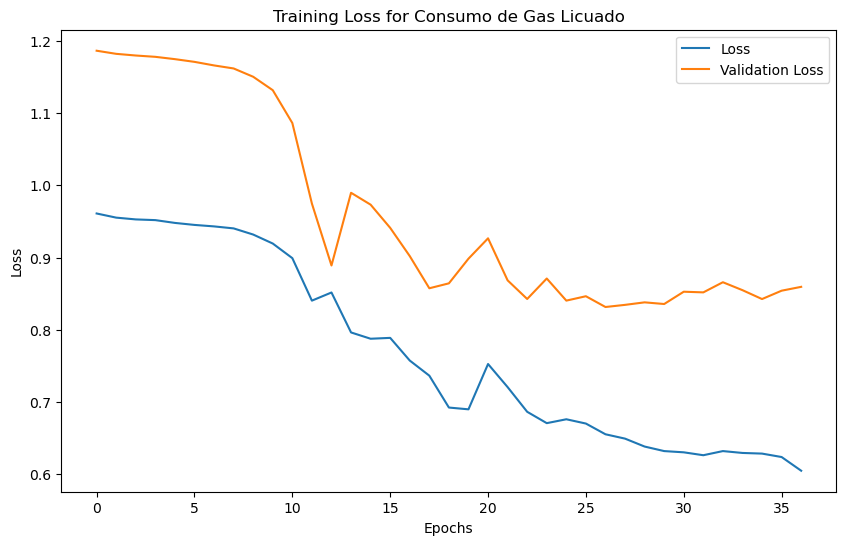

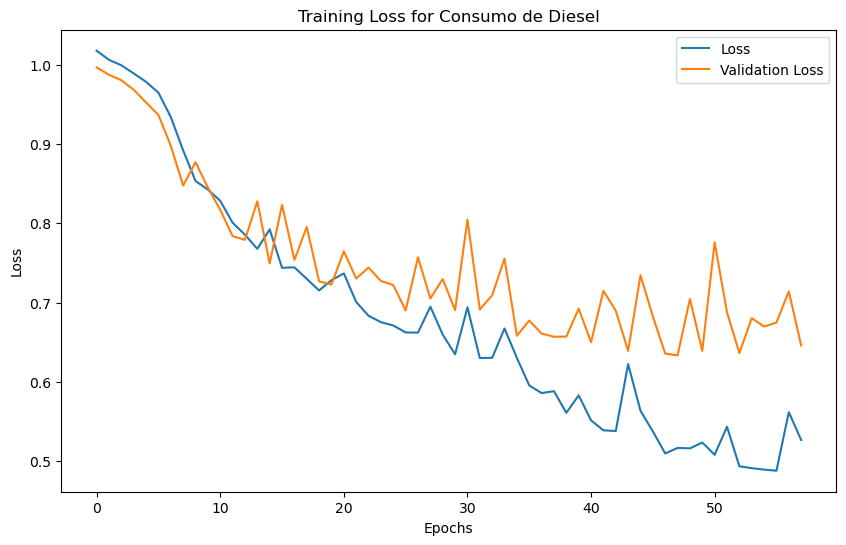

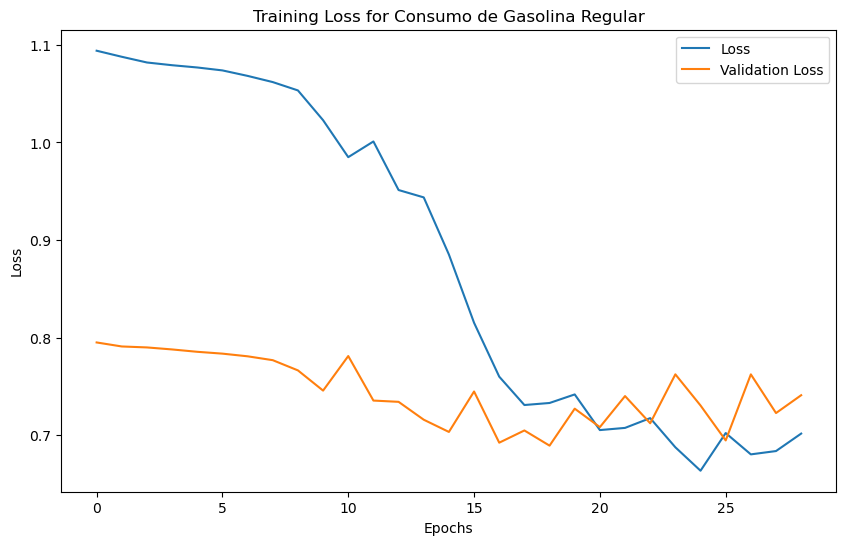

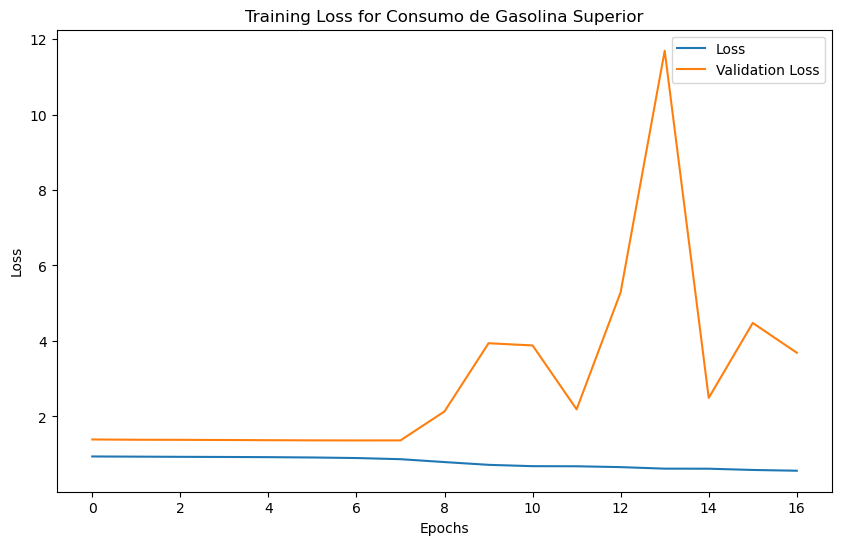

In [24]:
# Perdida de Gas Licuado
plt.figure(figsize=(10, 6))
plt.plot(history_consumo_gas_licuado.history['loss'], label='Loss')
plt.plot(history_consumo_gas_licuado.history['val_loss'], label='Validation Loss')
plt.title('Training Loss for Consumo de Gas Licuado')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Perdida de Diesel
plt.figure(figsize=(10, 6))
plt.plot(history_consumo_diesel.history['loss'], label='Loss')
plt.plot(history_consumo_diesel.history['val_loss'], label='Validation Loss')
plt.title('Training Loss for Consumo de Diesel')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()  

# Perdida de Regular
plt.figure(figsize=(10, 6))
plt.plot(history_consumo_regular.history['loss'], label='Loss')
plt.plot(history_consumo_regular.history['val_loss'], label='Validation Loss')
plt.title('Training Loss for Consumo de Gasolina Regular')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Perdida de Superior
plt.figure(figsize=(10, 6))
plt.plot(history_consumo_superior.history['loss'], label='Loss')
plt.plot(history_consumo_superior.history['val_loss'], label='Validation Loss')
plt.title('Training Loss for Consumo de Gasolina Superior') 
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Evaluacion del Modelo
Evaluamos el modelo utilizando la métrica de Root Mean Squared Error (RMSE).

In [25]:
# Evaluacion modelo Gas Licuado
y_pred_consumo_gas_licuado = model_consumo_gas_licuado.predict(X_test_consumo_gas_licuado)
rmse_consumo_gas_licuado = np.sqrt(mean_squared_error(y_test_consumo_gas_licuado, y_pred_consumo_gas_licuado))
print(f'RMSE for Consumo de Gas Licuado: {rmse_consumo_gas_licuado}')
print()

# Evaluacion modelo Diesel
y_pred_consumo_diesel = model_consumo_diesel.predict(X_test_consumo_diesel)
rmse_consumo_diesel = np.sqrt(mean_squared_error(y_test_consumo_diesel, y_pred_consumo_diesel)) 
print(f'RMSE for Consumo de Diesel: {rmse_consumo_diesel}')
print()

# Evaluacion modelo Regular
y_pred_consumo_regular = model_consumo_regular.predict(X_test_consumo_regular)
rmse_consumo_regular = np.sqrt(mean_squared_error(y_test_consumo_regular, y_pred_consumo_regular))
print(f'RMSE for Consumo de Gasolina Regular: {rmse_consumo_regular}')
print()

# Evaluacion modelo Superior
y_pred_consumo_superior = model_consumo_superior.predict(X_test_consumo_superior)
rmse_consumo_superior = np.sqrt(mean_squared_error(y_test_consumo_superior, y_pred_consumo_superior))
print(f'RMSE for Consumo de Gasolina Superior: {rmse_consumo_superior}')    


2/2 [==============================] - 0s 6ms/step
RMSE for Consumo de Gas Licuado: 0.9118794443393086

2/2 [==============================] - 0s 8ms/step
RMSE for Consumo de Diesel: 0.795967929212186

2/2 [==============================] - 0s 7ms/step
RMSE for Consumo de Gasolina Regular: 0.8303229991156887

2/2 [==============================] - 0s 5ms/step
RMSE for Consumo de Gasolina Superior: 1.1679961599096778


### Tuneo de parámetros
Implementamos un tuneo de parámetros variando el número de unidades en las capas LSTM y la tasa de aprendizaje del optimizador.

In [17]:
def tune_lstm_model(X_train, y_train, X_test, y_test, units_list, learning_rates):
    best_rmse = float('inf')
    best_model = None
    for units in units_list:
        for lr in learning_rates:
            model = Sequential()
            model.add(LSTM(units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
            model.add(LSTM(units, activation='relu'))
            model.add(Dense(1))
            model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')
            early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
            history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)
            y_pred = model.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            if rmse < best_rmse:
                best_rmse = rmse
                best_model = model
    return best_model

Aplicar el Tuneo de Parámetros a la Serie de Consumo

In [18]:
# Tuneo Gas Licuado
best_model_consumo_gas_licuado = tune_lstm_model(X_train_consumo_gas_licuado, y_train_consumo_gas_licuado, X_test_consumo_gas_licuado, y_test_consumo_gas_licuado, [50, 100], [0.001, 0.0001])

Epoch 1/50
7/7 [==============================] - 3s 97ms/step - loss: 0.9612 - val_loss: 1.1869
Epoch 2/50
7/7 [==============================] - 0s 17ms/step - loss: 0.9562 - val_loss: 1.1832
Epoch 3/50
7/7 [==============================] - 0s 19ms/step - loss: 0.9536 - val_loss: 1.1805
Epoch 4/50
7/7 [==============================] - 0s 31ms/step - loss: 0.9521 - val_loss: 1.1784
Epoch 5/50
7/7 [==============================] - 0s 21ms/step - loss: 0.9483 - val_loss: 1.1747
Epoch 6/50
7/7 [==============================] - 0s 20ms/step - loss: 0.9449 - val_loss: 1.1704
Epoch 7/50
7/7 [==============================] - 0s 18ms/step - loss: 0.9418 - val_loss: 1.1641
Epoch 8/50
7/7 [==============================] - 0s 19ms/step - loss: 0.9377 - val_loss: 1.1577
Epoch 9/50
7/7 [==============================] - 0s 18ms/step - loss: 0.9261 - val_loss: 1.1386
Epoch 10/50
7/7 [==============================] - 0s 18ms/step - loss: 0.9028 - val_loss: 1.0926
Epoch 11/50
7/7 [============

In [26]:
# Tuneo Diesel
best_model_consumo_diesel = tune_lstm_model(X_train_consumo_diesel, y_train_consumo_diesel, X_test_consumo_diesel, y_test_consumo_diesel, [50, 100], [0.001, 0.0001])

Epoch 1/50
7/7 [==============================] - 3s 100ms/step - loss: 1.0180 - val_loss: 0.9975
Epoch 2/50
7/7 [==============================] - 0s 17ms/step - loss: 1.0075 - val_loss: 0.9895
Epoch 3/50
7/7 [==============================] - 0s 20ms/step - loss: 1.0022 - val_loss: 0.9844
Epoch 4/50
7/7 [==============================] - 0s 18ms/step - loss: 0.9956 - val_loss: 0.9779
Epoch 5/50
7/7 [==============================] - 0s 18ms/step - loss: 0.9881 - val_loss: 0.9680
Epoch 6/50
7/7 [==============================] - 0s 18ms/step - loss: 0.9785 - val_loss: 0.9551
Epoch 7/50
7/7 [==============================] - 0s 19ms/step - loss: 0.9585 - val_loss: 0.9291
Epoch 8/50
7/7 [==============================] - 0s 18ms/step - loss: 0.9242 - val_loss: 0.8761
Epoch 9/50
7/7 [==============================] - 0s 18ms/step - loss: 0.8695 - val_loss: 0.8670
Epoch 10/50
7/7 [==============================] - 0s 18ms/step - loss: 0.8758 - val_loss: 0.8838
Epoch 11/50
7/7 [===========

In [27]:
# Tuneo Regular
best_model_consumo_regular = tune_lstm_model(X_train_consumo_regular, y_train_consumo_regular, X_test_consumo_regular, y_test_consumo_regular, [50, 100], [0.001, 0.0001])

Epoch 1/50
7/7 [==============================] - 3s 100ms/step - loss: 1.0959 - val_loss: 0.7975
Epoch 2/50
7/7 [==============================] - 0s 17ms/step - loss: 1.0896 - val_loss: 0.7925
Epoch 3/50
7/7 [==============================] - 0s 18ms/step - loss: 1.0828 - val_loss: 0.7917
Epoch 4/50
7/7 [==============================] - 0s 18ms/step - loss: 1.0799 - val_loss: 0.7896
Epoch 5/50
7/7 [==============================] - 0s 18ms/step - loss: 1.0779 - val_loss: 0.7876
Epoch 6/50
7/7 [==============================] - 0s 18ms/step - loss: 1.0747 - val_loss: 0.7858
Epoch 7/50
7/7 [==============================] - 0s 19ms/step - loss: 1.0681 - val_loss: 0.7829
Epoch 8/50
7/7 [==============================] - 0s 18ms/step - loss: 1.0606 - val_loss: 0.7792
Epoch 9/50
7/7 [==============================] - 0s 18ms/step - loss: 1.0515 - val_loss: 0.7718
Epoch 10/50
7/7 [==============================] - 0s 19ms/step - loss: 1.0249 - val_loss: 0.7669
Epoch 11/50
7/7 [===========

In [28]:
# Tuneo Superior
best_model_consumo_superior = tune_lstm_model(X_train_consumo_superior, y_train_consumo_superior, X_test_consumo_superior, y_test_consumo_superior, [50, 100], [0.001, 0.0001])

Epoch 1/50
7/7 [==============================] - 3s 97ms/step - loss: 0.9395 - val_loss: 1.3913
Epoch 2/50
7/7 [==============================] - 0s 20ms/step - loss: 0.9360 - val_loss: 1.3852
Epoch 3/50
7/7 [==============================] - 0s 18ms/step - loss: 0.9332 - val_loss: 1.3835
Epoch 4/50
7/7 [==============================] - 0s 19ms/step - loss: 0.9312 - val_loss: 1.3810
Epoch 5/50
7/7 [==============================] - 0s 19ms/step - loss: 0.9292 - val_loss: 1.3765
Epoch 6/50
7/7 [==============================] - 0s 19ms/step - loss: 0.9259 - val_loss: 1.3732
Epoch 7/50
7/7 [==============================] - 0s 19ms/step - loss: 0.9217 - val_loss: 1.3697
Epoch 8/50
7/7 [==============================] - 0s 19ms/step - loss: 0.9156 - val_loss: 1.3644
Epoch 9/50
7/7 [==============================] - 0s 19ms/step - loss: 0.9026 - val_loss: 1.3510
Epoch 10/50
7/7 [==============================] - 0s 20ms/step - loss: 0.8699 - val_loss: 1.4408
Epoch 11/50
7/7 [============

## Evaluacion
Utilizamos el mejor modelo para hacer predicciones y calculamos el RMSE.

In [29]:
# Evaluacion modelo Gas Licuado
y_pred_best_consumo_gas_licuado = best_model_consumo_gas_licuado.predict(X_test_consumo_gas_licuado)
best_rmse_consumo_gas_licuado = np.sqrt(mean_squared_error(y_test_consumo_gas_licuado, y_pred_best_consumo_gas_licuado))
print(f'Best RMSE for Consumo de Gas Licuado after tuning: {best_rmse_consumo_gas_licuado}')
print()

# Evaluacion modelo Diesel
y_pred_best_consumo_diesel = best_model_consumo_diesel.predict(X_test_consumo_diesel)
best_rmse_consumo_diesel = np.sqrt(mean_squared_error(y_test_consumo_diesel, y_pred_best_consumo_diesel))
print(f'Best RMSE for Consumo de Diesel after tuning: {best_rmse_consumo_diesel}')
print()

# Evaluacion modelo Regular
y_pred_best_consumo_regular = best_model_consumo_regular.predict(X_test_consumo_regular)
best_rmse_consumo_regular = np.sqrt(mean_squared_error(y_test_consumo_regular, y_pred_best_consumo_regular))
print(f'Best RMSE for Consumo de Gasolina Regular after tuning: {best_rmse_consumo_regular}')
print()

# Evaluacion modelo Superior
y_pred_best_consumo_superior = best_model_consumo_superior.predict(X_test_consumo_superior)
best_rmse_consumo_superior = np.sqrt(mean_squared_error(y_test_consumo_superior, y_pred_best_consumo_superior))
print(f'Best RMSE for Consumo de Gasolina Superior after tuning: {best_rmse_consumo_superior}')

2/2 [==============================] - 0s 7ms/step
Best RMSE for Consumo de Gas Licuado after tuning: 0.8940388348562487

2/2 [==============================] - 0s 16ms/step
Best RMSE for Consumo de Diesel after tuning: 0.7894927833349331

2/2 [==============================] - 0s 12ms/step
Best RMSE for Consumo de Gasolina Regular after tuning: 0.7914679715755282

2/2 [==============================] - 0s 6ms/step
Best RMSE for Consumo de Gasolina Superior after tuning: 1.1623421779334682


### Guardar Modelo para la Serie Consumo

In [64]:
# Guardar los modelos
best_model_consumo_gas_licuado.save('BestModels/CONSUMO-M1/best_model_consumo_gas_licuado.h5')
best_model_consumo_diesel.save('BestModels/CONSUMO-M1/best_model_consumo_diesel.h5')
best_model_consumo_regular.save('BestModels/CONSUMO-M1/best_model_consumo_regular.h5')
best_model_consumo_superior.save('BestModels/CONSUMO-M1/best_model_consumo_superior.h5')

## Modelo LSTM #2 para la serie CONSUMO
Definimos una función para crear un modelo LSTM con una arquitectura básica.... AQUI EMPEZAR EL MODELO 2

In [25]:
# Entrenamiento Gas Licuado
model_consumo_gas_licuado = create_lstm_model2((X_train_consumo_gas_licuado.shape[1], X_train_consumo_gas_licuado.shape[2]))
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history_consumo_gas_licuado = model_consumo_gas_licuado.fit(X_train_consumo_gas_licuado, y_train_consumo_gas_licuado, epochs=100, validation_data=(X_test_consumo_gas_licuado, y_test_consumo_gas_licuado), callbacks=[early_stopping], verbose=1)

Epoch 1/100


2024-08-11 13:14:55.383923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 5.6453

2024-08-11 13:14:58.445877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 5s 377ms/step - loss: 5.6453 - val_loss: 7.1322
Epoch 2/100
7/7 [==============================] - 2s 299ms/step - loss: 4.7448 - val_loss: 7.4896
Epoch 3/100
7/7 [==============================] - 2s 289ms/step - loss: 4.5201 - val_loss: 7.7436
Epoch 4/100
7/7 [==============================] - 2s 289ms/step - loss: 4.4715 - val_loss: 7.7792
Epoch 5/100
7/7 [==============================] - 2s 289ms/step - loss: 4.2137 - val_loss: 7.7209
Epoch 6/100
7/7 [==============================] - 2s 291ms/step - loss: 3.9394 - val_loss: 7.6938
Epoch 7/100
7/7 [==============================] - 2s 291ms/step - loss: 3.8435 - val_loss: 7.6693
Epoch 8/100
7/7 [==============================] - 2s 290ms/step - loss: 3.7520 - val_loss: 7.6087
Epoch 9/100
7/7 [==============================] - 2s 289ms/step - loss: 3.5700 - val_loss: 7.4544
Epoch 10/100
7/7 [==============================] - 2s 297ms/step - loss: 3.5669 - val_loss: 7.3069
Epoch 11/100
7/7 [===

In [31]:
# Entrenamiento Diesel
model_consumo_diesel2 = create_lstm_model2((X_train_consumo_diesel.shape[1], X_train_consumo_diesel.shape[2]))
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history_consumo_diesel2 = model_consumo_diesel2.fit(X_train_consumo_diesel, y_train_consumo_diesel, epochs=100, validation_data=(X_test_consumo_diesel, y_test_consumo_diesel), callbacks=[early_stopping], verbose=1)

Epoch 1/100


2024-08-11 13:30:11.419866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 5.8119

2024-08-11 13:30:14.762385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 5s 403ms/step - loss: 5.8119 - val_loss: 6.5162
Epoch 2/100
7/7 [==============================] - 2s 332ms/step - loss: 4.7218 - val_loss: 6.5658
Epoch 3/100
7/7 [==============================] - 2s 331ms/step - loss: 4.5156 - val_loss: 6.6133
Epoch 4/100
7/7 [==============================] - 2s 354ms/step - loss: 4.3382 - val_loss: 6.5956
Epoch 5/100
7/7 [==============================] - 2s 304ms/step - loss: 4.2159 - val_loss: 6.5276
Epoch 6/100
7/7 [==============================] - 2s 295ms/step - loss: 4.1042 - val_loss: 6.4977
Epoch 7/100
7/7 [==============================] - 2s 314ms/step - loss: 3.9377 - val_loss: 6.4623
Epoch 8/100
7/7 [==============================] - 2s 320ms/step - loss: 3.6959 - val_loss: 6.4303
Epoch 9/100
7/7 [==============================] - 2s 345ms/step - loss: 3.6534 - val_loss: 6.2330
Epoch 10/100
7/7 [==============================] - 2s 360ms/step - loss: 3.5097 - val_loss: 6.2116
Epoch 11/100
7/7 [===

In [27]:
# Entrenamiento Regular
model_consumo_regular2 = create_lstm_model2((X_train_consumo_regular.shape[1], X_train_consumo_regular.shape[2]))
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history_consumo_regular2 = model_consumo_regular2.fit(X_train_consumo_regular, y_train_consumo_regular, epochs=100, validation_data=(X_test_consumo_regular, y_test_consumo_regular), callbacks=[early_stopping], verbose=1)

Epoch 1/100


2024-08-11 13:20:25.117354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 6.6659

2024-08-11 13:20:28.330739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 4s 388ms/step - loss: 6.6659 - val_loss: 7.0412
Epoch 2/100
7/7 [==============================] - 2s 298ms/step - loss: 4.6249 - val_loss: 7.1765
Epoch 3/100
7/7 [==============================] - 2s 296ms/step - loss: 4.2638 - val_loss: 7.3973
Epoch 4/100
7/7 [==============================] - 2s 294ms/step - loss: 4.2265 - val_loss: 7.5230
Epoch 5/100
7/7 [==============================] - 2s 297ms/step - loss: 4.0181 - val_loss: 7.5503
Epoch 6/100
7/7 [==============================] - 2s 297ms/step - loss: 3.8704 - val_loss: 7.5001
Epoch 7/100
7/7 [==============================] - 2s 304ms/step - loss: 3.9198 - val_loss: 7.4384
Epoch 8/100
7/7 [==============================] - 2s 292ms/step - loss: 3.6504 - val_loss: 7.3927
Epoch 9/100
7/7 [==============================] - 2s 295ms/step - loss: 3.5645 - val_loss: 7.2749
Epoch 10/100
7/7 [==============================] - 2s 296ms/step - loss: 3.4744 - val_loss: 7.1950
Epoch 11/100
7/7 [===

In [33]:
# Entrenamiento Superior
model_consumo_superior2 = create_lstm_model2((X_train_consumo_superior.shape[1], X_train_consumo_superior.shape[2]))
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history_consumo_superior2 = model_consumo_superior2.fit(X_train_consumo_superior, y_train_consumo_superior, epochs=100, validation_data=(X_test_consumo_superior, y_test_consumo_superior), callbacks=[early_stopping], verbose=1)

Epoch 1/100


2024-08-11 13:37:01.371710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 6.8879

2024-08-11 13:37:04.904069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 5s 453ms/step - loss: 6.8879 - val_loss: 6.2442
Epoch 2/100
7/7 [==============================] - 3s 417ms/step - loss: 4.9357 - val_loss: 6.4024
Epoch 3/100
7/7 [==============================] - 3s 371ms/step - loss: 4.5220 - val_loss: 6.6250
Epoch 4/100
7/7 [==============================] - 2s 309ms/step - loss: 4.3532 - val_loss: 6.7526
Epoch 5/100
7/7 [==============================] - 2s 320ms/step - loss: 4.1620 - val_loss: 6.8190
Epoch 6/100
7/7 [==============================] - 2s 291ms/step - loss: 4.1129 - val_loss: 6.7442
Epoch 7/100
7/7 [==============================] - 2s 356ms/step - loss: 4.0717 - val_loss: 6.5716
Epoch 8/100
7/7 [==============================] - 2s 307ms/step - loss: 3.8776 - val_loss: 6.4930
Epoch 9/100
7/7 [==============================] - 2s 294ms/step - loss: 3.8269 - val_loss: 6.3997
Epoch 10/100
7/7 [==============================] - 2s 319ms/step - loss: 3.8382 - val_loss: 6.3891
Epoch 11/100
7/7 [===

### Loss model 2 for Consumo

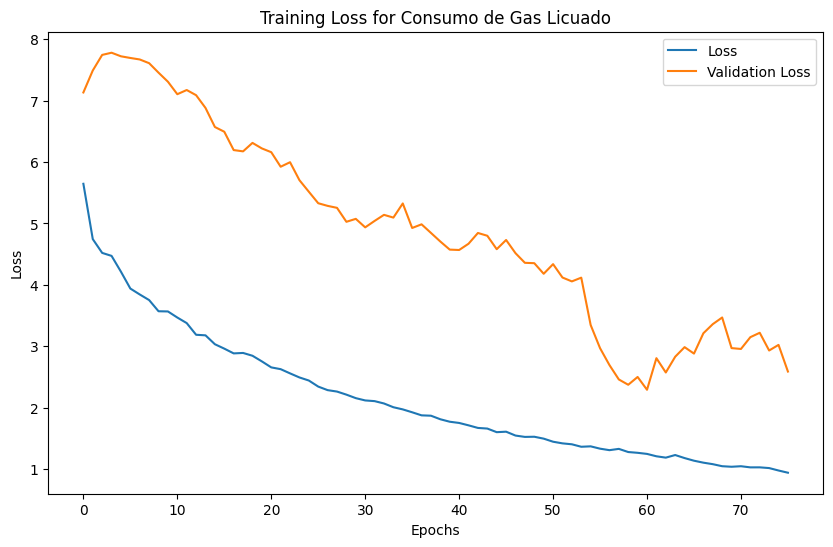

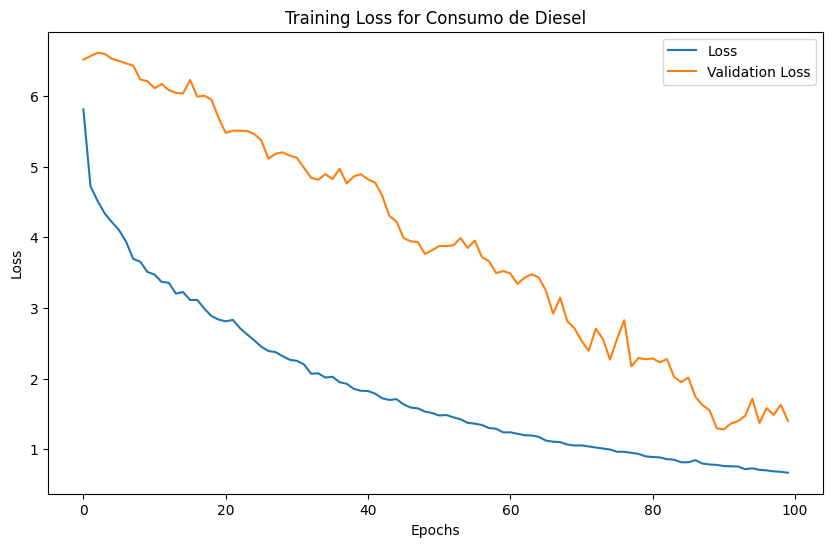

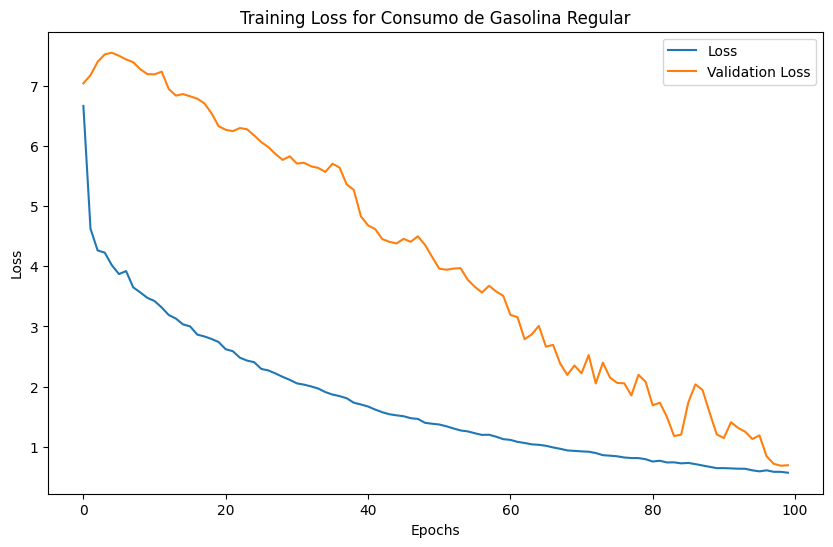

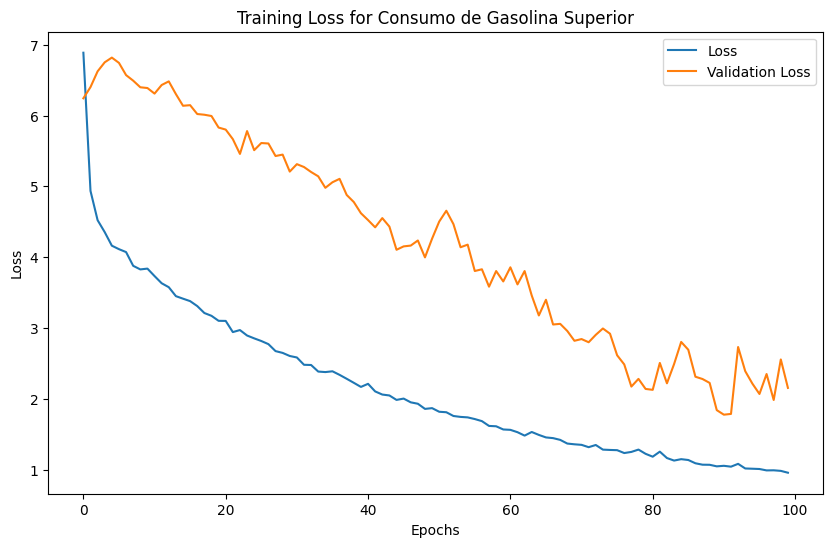

In [34]:
# Perdida de Gas Licuado
plt.figure(figsize=(10, 6))
plt.plot(history_consumo_gas_licuado.history['loss'], label='Loss')
plt.plot(history_consumo_gas_licuado.history['val_loss'], label='Validation Loss')
plt.title('Training Loss for Consumo de Gas Licuado')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Perdida de Diesel
plt.figure(figsize=(10, 6))
plt.plot(history_consumo_diesel2.history['loss'], label='Loss')
plt.plot(history_consumo_diesel2.history['val_loss'], label='Validation Loss')
plt.title('Training Loss for Consumo de Diesel')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()  

# Perdida de Regular
plt.figure(figsize=(10, 6))
plt.plot(history_consumo_regular2.history['loss'], label='Loss')
plt.plot(history_consumo_regular2.history['val_loss'], label='Validation Loss')
plt.title('Training Loss for Consumo de Gasolina Regular')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Perdida de Superior
plt.figure(figsize=(10, 6))
plt.plot(history_consumo_superior2.history['loss'], label='Loss')
plt.plot(history_consumo_superior2.history['val_loss'], label='Validation Loss')
plt.title('Training Loss for Consumo de Gasolina Superior') 
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model evaluation

In [35]:
# Evaluacion modelo Gas Licuado
y_pred_consumo_gas_licuado = model_consumo_gas_licuado.predict(X_test_consumo_gas_licuado)
rmse_consumo_gas_licuado = np.sqrt(mean_squared_error(y_test_consumo_gas_licuado, y_pred_consumo_gas_licuado))
print(f'RMSE for Consumo de Gas Licuado: {rmse_consumo_gas_licuado}')
print()

# Evaluacion modelo Diesel
y_pred_consumo_diesel = model_consumo_diesel2.predict(X_test_consumo_diesel)
rmse_consumo_diesel = np.sqrt(mean_squared_error(y_test_consumo_diesel, y_pred_consumo_diesel)) 
print(f'RMSE for Consumo de Diesel: {rmse_consumo_diesel}')
print()

# Evaluacion modelo Regular
y_pred_consumo_regular = model_consumo_regular2.predict(X_test_consumo_regular)
rmse_consumo_regular = np.sqrt(mean_squared_error(y_test_consumo_regular, y_pred_consumo_regular))
print(f'RMSE for Consumo de Gasolina Regular: {rmse_consumo_regular}')
print()

# Evaluacion modelo Superior
y_pred_consumo_superior = model_consumo_superior2.predict(X_test_consumo_superior)
rmse_consumo_superior = np.sqrt(mean_squared_error(y_test_consumo_superior, y_pred_consumo_superior))
print(f'RMSE for Consumo de Gasolina Superior: {rmse_consumo_superior}')    

2024-08-11 13:43:23.452909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 492ms/step
RMSE for Consumo de Gas Licuado: 1.0924928132536191



2024-08-11 13:43:24.757768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 181ms/step
RMSE for Consumo de Diesel: 0.9190725358218176



2024-08-11 13:43:25.384346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 225ms/step
RMSE for Consumo de Gasolina Regular: 0.4306307099919037



2024-08-11 13:43:26.041417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 231ms/step
RMSE for Consumo de Gasolina Superior: 1.1652247582700328


### Hyperparameter tuning

In [37]:
def tune_lstm_model2(X_train, y_train, X_test, y_test, units_list, learning_rates, l2_reg=0.01, dropout_rate=0.2):
    best_rmse = float('inf')
    best_model = None

    for units in units_list:
        for lr in learning_rates:
            model = Sequential()
            
            # First LSTM layer with L2 regularization, dropout, and batch normalization
            model.add(LSTM(units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), 
                           return_sequences=True, kernel_regularizer=l2(l2_reg)))
            model.add(Dropout(dropout_rate))
            model.add(BatchNormalization())
            
            # Second LSTM layer
            model.add(LSTM(units, activation='relu', return_sequences=True, kernel_regularizer=l2(l2_reg)))
            model.add(Dropout(dropout_rate))
            model.add(BatchNormalization())
            
            # Third LSTM layer
            model.add(LSTM(units, activation='relu', kernel_regularizer=l2(l2_reg)))
            model.add(Dropout(dropout_rate))
            model.add(BatchNormalization())
            
            # Dense layer
            model.add(Dense(50, activation='relu', kernel_regularizer=l2(l2_reg)))
            model.add(Dropout(dropout_rate))
            
            # Output layer
            model.add(Dense(1))
            
            # Compile the model
            model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')
            
            # Early stopping to avoid overfitting
            early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
            
            # Train the model
            history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), 
                                callbacks=[early_stopping], verbose=1)
            
            # Predict and calculate RMSE
            y_pred = model.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            
            # Update the best model based on RMSE
            if rmse < best_rmse:
                best_rmse = rmse
                best_model = model

    return best_model

In [38]:
# Tuneo Gas Licuado
best_model_consumo_gas_licuado2 = tune_lstm_model2(X_train_consumo_gas_licuado, y_train_consumo_gas_licuado, X_test_consumo_gas_licuado, y_test_consumo_gas_licuado, [50, 100], [0.001, 0.0001])

Epoch 1/50


2024-08-11 13:47:11.248519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 3.6346

2024-08-11 13:47:15.246376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 6s 463ms/step - loss: 3.6346 - val_loss: 5.1788
Epoch 2/50
7/7 [==============================] - 2s 317ms/step - loss: 2.7033 - val_loss: 5.3415
Epoch 3/50
7/7 [==============================] - 2s 328ms/step - loss: 2.6819 - val_loss: 5.4757
Epoch 4/50
7/7 [==============================] - 2s 330ms/step - loss: 2.5529 - val_loss: 5.5302
Epoch 5/50
7/7 [==============================] - 2s 287ms/step - loss: 2.4174 - val_loss: 5.5271
Epoch 6/50
7/7 [==============================] - 2s 288ms/step - loss: 2.2635 - val_loss: 5.4871
Epoch 7/50
7/7 [==============================] - 2s 301ms/step - loss: 2.2177 - val_loss: 5.4517
Epoch 8/50
7/7 [==============================] - 2s 302ms/step - loss: 2.0758 - val_loss: 5.4446
Epoch 9/50
7/7 [==============================] - 2s 289ms/step - loss: 2.0364 - val_loss: 5.4298
Epoch 10/50
7/7 [==============================] - 2s 287ms/step - loss: 1.9990 - val_loss: 5.3560
Epoch 11/50
7/7 [=============

2024-08-11 13:47:37.080905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 181ms/step


Epoch 1/50


2024-08-11 13:47:38.427022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 4.4074

2024-08-11 13:47:42.328173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 5s 503ms/step - loss: 4.4074 - val_loss: 4.9885
Epoch 2/50
7/7 [==============================] - 2s 312ms/step - loss: 3.7941 - val_loss: 4.9301
Epoch 3/50
7/7 [==============================] - 2s 290ms/step - loss: 3.9002 - val_loss: 4.8912
Epoch 4/50
7/7 [==============================] - 2s 290ms/step - loss: 3.4941 - val_loss: 4.8564
Epoch 5/50
7/7 [==============================] - 2s 291ms/step - loss: 3.3968 - val_loss: 4.8293
Epoch 6/50
7/7 [==============================] - 2s 301ms/step - loss: 3.2459 - val_loss: 4.8005
Epoch 7/50
7/7 [==============================] - 2s 293ms/step - loss: 3.1408 - val_loss: 4.7695
Epoch 8/50
7/7 [==============================] - 2s 293ms/step - loss: 3.0279 - val_loss: 4.7474
Epoch 9/50
7/7 [==============================] - 2s 332ms/step - loss: 2.9227 - val_loss: 4.7265
Epoch 10/50
7/7 [==============================] - 2s 313ms/step - loss: 2.8491 - val_loss: 4.7034
Epoch 11/50
7/7 [=============

2024-08-11 13:49:30.649437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 195ms/step


Epoch 1/50


2024-08-11 13:49:32.086218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 5.0619

2024-08-11 13:49:36.536186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 6s 494ms/step - loss: 5.0619 - val_loss: 6.8938
Epoch 2/50
7/7 [==============================] - 3s 375ms/step - loss: 4.3189 - val_loss: 6.9959
Epoch 3/50
7/7 [==============================] - 3s 459ms/step - loss: 4.0972 - val_loss: 6.9888
Epoch 4/50
7/7 [==============================] - 3s 476ms/step - loss: 3.8700 - val_loss: 6.9719
Epoch 5/50
7/7 [==============================] - 2s 340ms/step - loss: 3.7989 - val_loss: 6.9003
Epoch 6/50
7/7 [==============================] - 2s 336ms/step - loss: 3.6086 - val_loss: 6.8018
Epoch 7/50
7/7 [==============================] - 2s 345ms/step - loss: 3.4540 - val_loss: 6.6465
Epoch 8/50
7/7 [==============================] - 2s 329ms/step - loss: 3.3552 - val_loss: 6.4781
Epoch 9/50
7/7 [==============================] - 2s 327ms/step - loss: 3.2617 - val_loss: 6.3433
Epoch 10/50
7/7 [==============================] - 2s 368ms/step - loss: 3.1314 - val_loss: 6.2729
Epoch 11/50
7/7 [=============

2024-08-11 13:51:40.684172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 208ms/step


Epoch 1/50


2024-08-11 13:51:42.684775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 6.7676

2024-08-11 13:51:47.748846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 7s 618ms/step - loss: 6.7676 - val_loss: 6.7621
Epoch 2/50
7/7 [==============================] - 3s 365ms/step - loss: 5.9153 - val_loss: 6.8200
Epoch 3/50
7/7 [==============================] - 2s 338ms/step - loss: 5.4092 - val_loss: 6.8779
Epoch 4/50
7/7 [==============================] - 2s 342ms/step - loss: 5.1230 - val_loss: 6.9358
Epoch 5/50
7/7 [==============================] - 3s 365ms/step - loss: 4.8426 - val_loss: 6.9912
Epoch 6/50
7/7 [==============================] - 2s 360ms/step - loss: 5.0066 - val_loss: 7.0496
Epoch 7/50
7/7 [==============================] - 3s 394ms/step - loss: 5.0023 - val_loss: 7.0891
Epoch 8/50
7/7 [==============================] - 3s 384ms/step - loss: 4.5913 - val_loss: 7.1160
Epoch 9/50
7/7 [==============================] - 3s 397ms/step - loss: 4.5205 - val_loss: 7.1510
Epoch 10/50
7/7 [==============================] - 2s 328ms/step - loss: 4.4613 - val_loss: 7.1950
Epoch 11/50
7/7 [=============

2024-08-11 13:52:13.595335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 217ms/step


In [39]:
# Tuneo Diesel
best_model_consumo_diesel2 = tune_lstm_model2(X_train_consumo_diesel, y_train_consumo_diesel, X_test_consumo_diesel, y_test_consumo_diesel, [50, 100], [0.001, 0.0001])

Epoch 1/50


2024-08-11 13:56:13.173373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 3.8091

2024-08-11 13:56:17.500614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 6s 537ms/step - loss: 3.8091 - val_loss: 4.8592
Epoch 2/50
7/7 [==============================] - 2s 347ms/step - loss: 2.9602 - val_loss: 4.9476
Epoch 3/50
7/7 [==============================] - 2s 315ms/step - loss: 2.7964 - val_loss: 5.0913
Epoch 4/50
7/7 [==============================] - 2s 304ms/step - loss: 2.6692 - val_loss: 5.1963
Epoch 5/50
7/7 [==============================] - 2s 305ms/step - loss: 2.4397 - val_loss: 5.2100
Epoch 6/50
7/7 [==============================] - 2s 305ms/step - loss: 2.4262 - val_loss: 5.1999
Epoch 7/50
7/7 [==============================] - 2s 312ms/step - loss: 2.3085 - val_loss: 5.1112
Epoch 8/50
7/7 [==============================] - 2s 313ms/step - loss: 2.1968 - val_loss: 5.0001
Epoch 9/50
7/7 [==============================] - 2s 302ms/step - loss: 2.1050 - val_loss: 4.9201
Epoch 10/50
7/7 [==============================] - 2s 309ms/step - loss: 2.0861 - val_loss: 4.8647
Epoch 11/50
7/7 [=============

2024-08-11 13:58:06.166461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 259ms/step


Epoch 1/50


2024-08-11 13:58:07.738363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 4.6746

2024-08-11 13:58:11.746783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 6s 480ms/step - loss: 4.6746 - val_loss: 4.6451
Epoch 2/50
7/7 [==============================] - 2s 335ms/step - loss: 4.4897 - val_loss: 4.6723
Epoch 3/50
7/7 [==============================] - 2s 336ms/step - loss: 3.9671 - val_loss: 4.6967
Epoch 4/50
7/7 [==============================] - 2s 335ms/step - loss: 4.0188 - val_loss: 4.7067
Epoch 5/50
7/7 [==============================] - 2s 336ms/step - loss: 3.9302 - val_loss: 4.7167
Epoch 6/50
7/7 [==============================] - 2s 341ms/step - loss: 3.5144 - val_loss: 4.7199
Epoch 7/50
7/7 [==============================] - 2s 334ms/step - loss: 3.4665 - val_loss: 4.7248
Epoch 8/50
7/7 [==============================] - 2s 333ms/step - loss: 3.6694 - val_loss: 4.7252
Epoch 9/50
7/7 [==============================] - 2s 337ms/step - loss: 3.4174 - val_loss: 4.7239
Epoch 10/50
7/7 [==============================] - 2s 346ms/step - loss: 3.2939 - val_loss: 4.7300
Epoch 11/50
7/7 [=============

2024-08-11 13:58:36.075394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 250ms/step


Epoch 1/50


2024-08-11 13:58:37.559646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 5.6870

2024-08-11 13:58:41.759739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 6s 499ms/step - loss: 5.6870 - val_loss: 6.5360
Epoch 2/50
7/7 [==============================] - 2s 359ms/step - loss: 5.0694 - val_loss: 6.7081
Epoch 3/50
7/7 [==============================] - 2s 339ms/step - loss: 4.7768 - val_loss: 6.8896
Epoch 4/50
7/7 [==============================] - 2s 347ms/step - loss: 4.5303 - val_loss: 7.0168
Epoch 5/50
7/7 [==============================] - 2s 340ms/step - loss: 4.3504 - val_loss: 6.9208
Epoch 6/50
7/7 [==============================] - 2s 349ms/step - loss: 4.2790 - val_loss: 6.8590
Epoch 7/50
7/7 [==============================] - 2s 349ms/step - loss: 4.0201 - val_loss: 6.8316
Epoch 8/50
7/7 [==============================] - 2s 357ms/step - loss: 3.9056 - val_loss: 6.8327
Epoch 9/50
7/7 [==============================] - 2s 346ms/step - loss: 3.8652 - val_loss: 6.6734
Epoch 10/50
7/7 [==============================] - 2s 349ms/step - loss: 3.6957 - val_loss: 6.5862
Epoch 11/50
7/7 [=============

2024-08-11 14:00:41.895433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 252ms/step


Epoch 1/50


2024-08-11 14:00:45.120222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 7.2199

2024-08-11 14:00:49.350136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 7s 516ms/step - loss: 7.2199 - val_loss: 6.3455
Epoch 2/50
7/7 [==============================] - 2s 350ms/step - loss: 6.0802 - val_loss: 6.3519
Epoch 3/50
7/7 [==============================] - 2s 347ms/step - loss: 5.7190 - val_loss: 6.3523
Epoch 4/50
7/7 [==============================] - 2s 346ms/step - loss: 5.4650 - val_loss: 6.3494
Epoch 5/50
7/7 [==============================] - 2s 356ms/step - loss: 5.2220 - val_loss: 6.3450
Epoch 6/50
7/7 [==============================] - 2s 358ms/step - loss: 5.4808 - val_loss: 6.3468
Epoch 7/50
7/7 [==============================] - 2s 358ms/step - loss: 5.0143 - val_loss: 6.3471
Epoch 8/50
7/7 [==============================] - 2s 350ms/step - loss: 5.0340 - val_loss: 6.3393
Epoch 9/50
7/7 [==============================] - 2s 352ms/step - loss: 4.9163 - val_loss: 6.3337
Epoch 10/50
7/7 [==============================] - 2s 354ms/step - loss: 4.6248 - val_loss: 6.3066
Epoch 11/50
7/7 [=============

2024-08-11 14:02:51.498776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 256ms/step


In [40]:
# Tuneo Regular
best_model_consumo_regular2 = tune_lstm_model2(X_train_consumo_regular, y_train_consumo_regular, X_test_consumo_regular, y_test_consumo_regular, [50, 100], [0.001, 0.0001])

Epoch 1/50


2024-08-11 14:03:47.142871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 4.1141

2024-08-11 14:03:51.124547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 6s 457ms/step - loss: 4.1141 - val_loss: 5.2031
Epoch 2/50
7/7 [==============================] - 2s 317ms/step - loss: 2.9021 - val_loss: 5.4845
Epoch 3/50
7/7 [==============================] - 2s 308ms/step - loss: 2.5837 - val_loss: 5.7237
Epoch 4/50
7/7 [==============================] - 2s 303ms/step - loss: 2.5274 - val_loss: 5.8999
Epoch 5/50
7/7 [==============================] - 2s 305ms/step - loss: 2.2998 - val_loss: 5.9950
Epoch 6/50
7/7 [==============================] - 2s 301ms/step - loss: 2.3439 - val_loss: 6.0534
Epoch 7/50
7/7 [==============================] - 2s 304ms/step - loss: 2.1353 - val_loss: 6.1127
Epoch 8/50
7/7 [==============================] - 2s 308ms/step - loss: 2.1338 - val_loss: 6.2252
Epoch 9/50
7/7 [==============================] - 2s 302ms/step - loss: 2.0325 - val_loss: 6.2322
Epoch 10/50
7/7 [==============================] - 2s 313ms/step - loss: 2.0114 - val_loss: 6.1121
Epoch 11/50
7/7 [=============

2024-08-11 14:04:13.270276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 251ms/step


Epoch 1/50


2024-08-11 14:04:14.791250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 4.7595

2024-08-11 14:04:18.792171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 5s 460ms/step - loss: 4.7595 - val_loss: 4.9782
Epoch 2/50
7/7 [==============================] - 2s 318ms/step - loss: 4.2200 - val_loss: 4.9512
Epoch 3/50
7/7 [==============================] - 2s 313ms/step - loss: 4.2462 - val_loss: 4.9555
Epoch 4/50
7/7 [==============================] - 2s 320ms/step - loss: 3.7180 - val_loss: 4.9490
Epoch 5/50
7/7 [==============================] - 2s 312ms/step - loss: 3.6683 - val_loss: 4.9487
Epoch 6/50
7/7 [==============================] - 2s 317ms/step - loss: 3.4329 - val_loss: 4.9657
Epoch 7/50
7/7 [==============================] - 2s 317ms/step - loss: 3.3130 - val_loss: 4.9855
Epoch 8/50
7/7 [==============================] - 2s 324ms/step - loss: 3.3211 - val_loss: 5.0133
Epoch 9/50
7/7 [==============================] - 2s 318ms/step - loss: 2.9244 - val_loss: 5.0489
Epoch 10/50
7/7 [==============================] - 2s 323ms/step - loss: 2.9888 - val_loss: 5.0760
Epoch 11/50
7/7 [=============

2024-08-11 14:04:50.723211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 238ms/step


Epoch 1/50


2024-08-11 14:04:52.261077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 4.9957

2024-08-11 14:04:56.346812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 6s 490ms/step - loss: 4.9957 - val_loss: 6.9672
Epoch 2/50
7/7 [==============================] - 2s 336ms/step - loss: 4.4398 - val_loss: 7.0802
Epoch 3/50
7/7 [==============================] - 2s 335ms/step - loss: 4.1376 - val_loss: 7.2066
Epoch 4/50
7/7 [==============================] - 2s 347ms/step - loss: 3.9582 - val_loss: 7.2344
Epoch 5/50
7/7 [==============================] - 2s 335ms/step - loss: 3.7545 - val_loss: 7.2002
Epoch 6/50
7/7 [==============================] - 2s 340ms/step - loss: 3.6736 - val_loss: 7.0749
Epoch 7/50
7/7 [==============================] - 2s 347ms/step - loss: 3.5235 - val_loss: 6.7801
Epoch 8/50
7/7 [==============================] - 2s 342ms/step - loss: 3.3637 - val_loss: 6.6636
Epoch 9/50
7/7 [==============================] - 2s 335ms/step - loss: 3.2061 - val_loss: 6.5080
Epoch 10/50
7/7 [==============================] - 2s 341ms/step - loss: 3.1099 - val_loss: 6.5005
Epoch 11/50
7/7 [=============

2024-08-11 14:06:55.434881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 267ms/step


Epoch 1/50


2024-08-11 14:06:56.993641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 6.7460

2024-08-11 14:07:01.364676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 6s 534ms/step - loss: 6.7460 - val_loss: 6.7596
Epoch 2/50
7/7 [==============================] - 3s 389ms/step - loss: 6.3368 - val_loss: 6.7408
Epoch 3/50
7/7 [==============================] - 3s 383ms/step - loss: 5.5180 - val_loss: 6.7500
Epoch 4/50
7/7 [==============================] - 3s 392ms/step - loss: 5.1144 - val_loss: 6.7843
Epoch 5/50
7/7 [==============================] - 3s 417ms/step - loss: 5.0185 - val_loss: 6.8220
Epoch 6/50
7/7 [==============================] - 3s 402ms/step - loss: 4.6987 - val_loss: 6.8520
Epoch 7/50
7/7 [==============================] - 3s 390ms/step - loss: 4.8466 - val_loss: 6.8897
Epoch 8/50
7/7 [==============================] - 3s 407ms/step - loss: 4.4424 - val_loss: 6.9263
Epoch 9/50
7/7 [==============================] - 3s 406ms/step - loss: 4.5769 - val_loss: 6.9836
Epoch 10/50
7/7 [==============================] - 3s 520ms/step - loss: 4.4923 - val_loss: 7.0277
Epoch 11/50
7/7 [=============

2024-08-11 14:07:34.069380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 239ms/step


In [42]:
# Tuneo Superior
best_model_consumo_superior2 = tune_lstm_model2(X_train_consumo_superior, y_train_consumo_superior, X_test_consumo_superior, y_test_consumo_superior, [50, 100], [0.001, 0.0001])

Epoch 1/50


2024-08-11 14:16:07.683163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 3.6602

2024-08-11 14:16:12.352973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 6s 491ms/step - loss: 3.6602 - val_loss: 4.4699
Epoch 2/50
7/7 [==============================] - 2s 346ms/step - loss: 2.7638 - val_loss: 4.6400
Epoch 3/50
7/7 [==============================] - 3s 410ms/step - loss: 2.5698 - val_loss: 4.7932
Epoch 4/50
7/7 [==============================] - 3s 512ms/step - loss: 2.4517 - val_loss: 4.8886
Epoch 5/50
7/7 [==============================] - 4s 520ms/step - loss: 2.3601 - val_loss: 4.9359
Epoch 6/50
7/7 [==============================] - 4s 541ms/step - loss: 2.2091 - val_loss: 4.9897
Epoch 7/50
7/7 [==============================] - 4s 528ms/step - loss: 2.2123 - val_loss: 4.9867
Epoch 8/50
7/7 [==============================] - 4s 527ms/step - loss: 2.1653 - val_loss: 4.9428
Epoch 9/50
7/7 [==============================] - 4s 531ms/step - loss: 2.0695 - val_loss: 4.8673
Epoch 10/50
7/7 [==============================] - 4s 561ms/step - loss: 2.0259 - val_loss: 4.8166
Epoch 11/50
7/7 [=============

2024-08-11 14:16:47.770865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 305ms/step


Epoch 1/50


2024-08-11 14:16:49.553006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 4.5907

2024-08-11 14:16:55.655894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 8s 777ms/step - loss: 4.5907 - val_loss: 4.3589
Epoch 2/50
7/7 [==============================] - 5s 692ms/step - loss: 3.8944 - val_loss: 4.3402
Epoch 3/50
7/7 [==============================] - 4s 601ms/step - loss: 3.9589 - val_loss: 4.3328
Epoch 4/50
7/7 [==============================] - 4s 600ms/step - loss: 3.8418 - val_loss: 4.3204
Epoch 5/50
7/7 [==============================] - 4s 607ms/step - loss: 3.5214 - val_loss: 4.3105
Epoch 6/50
7/7 [==============================] - 4s 592ms/step - loss: 3.4302 - val_loss: 4.3112
Epoch 7/50
7/7 [==============================] - 4s 589ms/step - loss: 3.3089 - val_loss: 4.3186
Epoch 8/50
7/7 [==============================] - 4s 600ms/step - loss: 3.2055 - val_loss: 4.3189
Epoch 9/50
7/7 [==============================] - 4s 590ms/step - loss: 3.2432 - val_loss: 4.3229
Epoch 10/50
7/7 [==============================] - 4s 593ms/step - loss: 3.1634 - val_loss: 4.3300
Epoch 11/50
7/7 [=============

2024-08-11 14:17:55.108202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 437ms/step


Epoch 1/50


2024-08-11 14:17:57.143778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 6.6761

2024-08-11 14:18:04.214265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 9s 900ms/step - loss: 6.6761 - val_loss: 6.2635
Epoch 2/50
7/7 [==============================] - 4s 660ms/step - loss: 5.3380 - val_loss: 6.4358
Epoch 3/50
7/7 [==============================] - 4s 639ms/step - loss: 4.7875 - val_loss: 6.5909
Epoch 4/50
7/7 [==============================] - 4s 620ms/step - loss: 4.8052 - val_loss: 6.7149
Epoch 5/50
7/7 [==============================] - 4s 633ms/step - loss: 4.4664 - val_loss: 6.7870
Epoch 6/50
7/7 [==============================] - 4s 634ms/step - loss: 4.2240 - val_loss: 6.8694
Epoch 7/50
7/7 [==============================] - 4s 616ms/step - loss: 4.2142 - val_loss: 6.7660
Epoch 8/50
7/7 [==============================] - 4s 627ms/step - loss: 3.9781 - val_loss: 6.7461
Epoch 9/50
7/7 [==============================] - 4s 626ms/step - loss: 3.8231 - val_loss: 6.5981
Epoch 10/50
7/7 [==============================] - 4s 613ms/step - loss: 3.7769 - val_loss: 6.4811
Epoch 11/50
7/7 [=============

2024-08-11 14:18:48.580473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 453ms/step


Epoch 1/50


2024-08-11 14:18:50.740384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 5.7297

2024-08-11 14:18:57.839623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 9s 922ms/step - loss: 5.7297 - val_loss: 6.0574
Epoch 2/50
7/7 [==============================] - 5s 690ms/step - loss: 5.3291 - val_loss: 6.0260
Epoch 3/50
7/7 [==============================] - 5s 662ms/step - loss: 4.9371 - val_loss: 5.9944
Epoch 4/50
7/7 [==============================] - 4s 631ms/step - loss: 4.8843 - val_loss: 5.9509
Epoch 5/50
7/7 [==============================] - 4s 620ms/step - loss: 4.7664 - val_loss: 5.9138
Epoch 6/50
7/7 [==============================] - 4s 648ms/step - loss: 4.6974 - val_loss: 5.8733
Epoch 7/50
7/7 [==============================] - 5s 689ms/step - loss: 4.7716 - val_loss: 5.8462
Epoch 8/50
7/7 [==============================] - 4s 613ms/step - loss: 4.4736 - val_loss: 5.8269
Epoch 9/50
7/7 [==============================] - 4s 622ms/step - loss: 4.3569 - val_loss: 5.8065
Epoch 10/50
7/7 [==============================] - 4s 622ms/step - loss: 4.4822 - val_loss: 5.7827
Epoch 11/50
7/7 [=============

2024-08-11 14:22:34.860872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 451ms/step


In [45]:
# Evaluacion modelo Gas Licuado
y_pred_best_consumo_gas_licuado2 = best_model_consumo_gas_licuado2.predict(X_test_consumo_gas_licuado)
best_rmse_consumo_gas_licuado2 = np.sqrt(mean_squared_error(y_test_consumo_gas_licuado, y_pred_best_consumo_gas_licuado2))
print(f'Best RMSE for Consumo de Gas Licuado after tuning: {best_rmse_consumo_gas_licuado2}')
print()

# Evaluacion modelo Diesel
y_pred_best_consumo_diesel2 = best_model_consumo_diesel2.predict(X_test_consumo_diesel)
best_rmse_consumo_diesel2 = np.sqrt(mean_squared_error(y_test_consumo_diesel, y_pred_best_consumo_diesel2))
print(f'Best RMSE for Consumo de Diesel after tuning: {best_rmse_consumo_diesel2}')
print()

# Evaluacion modelo Regular
y_pred_best_consumo_regular2 = best_model_consumo_regular2.predict(X_test_consumo_regular)
best_rmse_consumo_regular2 = np.sqrt(mean_squared_error(y_test_consumo_regular, y_pred_best_consumo_regular2))
print(f'Best RMSE for Consumo de Gasolina Regular after tuning: {best_rmse_consumo_regular2}')
print()

# Evaluacion modelo Superior
y_pred_best_consumo_superior2 = best_model_consumo_superior2.predict(X_test_consumo_superior)
best_rmse_consumo_superior2 = np.sqrt(mean_squared_error(y_test_consumo_superior, y_pred_best_consumo_superior2))
print(f'Best RMSE for Consumo de Gasolina Superior after tuning: {best_rmse_consumo_superior2}')

2/2 [==============================] - 0s 75ms/step
Best RMSE for Consumo de Gas Licuado after tuning: 0.9648502711232559

2/2 [==============================] - 0s 92ms/step
Best RMSE for Consumo de Diesel after tuning: 1.2038303939565476

2/2 [==============================] - 0s 65ms/step
Best RMSE for Consumo de Gasolina Regular after tuning: 1.6888328782416413

2/2 [==============================] - 0s 65ms/step
Best RMSE for Consumo de Gasolina Superior after tuning: 1.0728003026197852


In [46]:
# Guardar los modelos
best_model_consumo_gas_licuado2.save('BestModels/CONSUMO-M2/best_model_consumo_gas_licuado.h5')
model_consumo_diesel2.save('BestModels/CONSUMO-M2/best_model_consumo_diesel.h5')
model_consumo_regular2.save('BestModels/CONSUMO-M2/best_model_consumo_regular.h5')
best_model_consumo_superior2.save('BestModels/CONSUMO-M2/best_model_consumo_superior.h5')

/Users/gustavogonzalez/miniconda3/envs/lstm_lab/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# SERIE IMPORTACION

### Division de conjunto de datos
Dividimos los datos en conjuntos de entrenamiento (80%) y prueba (20%).

In [47]:
# Division de los datos de importacion
train_size = int(len(X_importacion_gas_licuado) * 0.8)

# Gas Licuado
X_train_importacion_gas_licuado, X_test_importacion_gas_licuado = X_importacion_gas_licuado[:train_size], X_importacion_gas_licuado[train_size:]
y_train_importacion_gas_licuado, y_test_importacion_gas_licuado = y_importacion_gas_licuado[:train_size], y_importacion_gas_licuado[train_size:]

# Diesel
X_train_importacion_diesel, X_test_importacion_diesel = X_importacion_diesel[:train_size], X_importacion_diesel[train_size:]
y_train_importacion_diesel, y_test_importacion_diesel = y_importacion_diesel[:train_size], y_importacion_diesel[train_size:]

# Regular
X_train_importacion_regular, X_test_importacion_regular = X_importacion_regular[:train_size], X_importacion_regular[train_size:]
y_train_importacion_regular, y_test_importacion_regular = y_importacion_regular[:train_size], y_importacion_regular[train_size:]

# Superior
X_train_importacion_superior, X_test_importacion_superior = X_importacion_superior[:train_size], X_importacion_superior[train_size:]
y_train_importacion_superior, y_test_importacion_superior = y_importacion_superior[:train_size], y_importacion_superior[train_size:]

#### Entrenamiento para todos los combustibles
Entrenamos el modelo LSTM usando los datos de importacion.

In [48]:
# ya que el array es en 2D ajustamos la forma para que sea compatible con el modelo LSTM

# Gas licuado
if len(X_train_importacion_gas_licuado.shape) == 2:
    X_train_importacion_gas_licuado = np.expand_dims(X_train_importacion_gas_licuado, axis=-1)
    X_test_importacion_gas_licuado = np.expand_dims(X_test_importacion_gas_licuado, axis=-1)

print(f"Nuevas dimensiones de X_train_importacion_gas_licuado: {X_train_importacion_gas_licuado.shape}")

# Diesel
if len(X_train_importacion_diesel.shape) == 2:
    X_train_importacion_diesel = np.expand_dims(X_train_importacion_diesel, axis=-1)
    X_test_importacion_diesel = np.expand_dims(X_test_importacion_diesel, axis=-1)

print(f"Nuevas dimensiones de X_train_importacion_diesel: {X_train_importacion_diesel.shape}")

# Regular
if len(X_train_importacion_regular.shape) == 2:
    X_train_importacion_regular = np.expand_dims(X_train_importacion_regular, axis=-1)
    X_test_importacion_regular = np.expand_dims(X_test_importacion_regular, axis=-1)

print(f"Nuevas dimensiones de X_train_importacion_regular: {X_train_importacion_regular.shape}")

# Superior
if len(X_train_importacion_superior.shape) == 2:
    X_train_importacion_superior = np.expand_dims(X_train_importacion_superior, axis=-1)
    X_test_importacion_superior = np.expand_dims(X_test_importacion_superior, axis=-1)

print(f"Nuevas dimensiones de X_train_importacion_superior: {X_train_importacion_superior.shape}")

Nuevas dimensiones de X_train_importacion_gas_licuado: (215, 12, 1)
Nuevas dimensiones de X_train_importacion_diesel: (215, 12, 1)
Nuevas dimensiones de X_train_importacion_regular: (215, 12, 1)
Nuevas dimensiones de X_train_importacion_superior: (215, 12, 1)


In [32]:
# Entrenamiento Gas Licuado
model_importacion_gas_licuado = create_lstm_model((X_train_importacion_gas_licuado.shape[1], X_train_importacion_gas_licuado.shape[2]))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_importacion_gas_licuado = model_importacion_gas_licuado.fit(X_train_importacion_gas_licuado, y_train_importacion_gas_licuado, epochs=100, validation_data=(X_test_importacion_gas_licuado, y_test_importacion_gas_licuado), callbacks=[early_stopping], verbose=1)

Epoch 1/100
7/7 [==============================] - 4s 101ms/step - loss: 1.1460 - val_loss: 0.6063
Epoch 2/100
7/7 [==============================] - 0s 20ms/step - loss: 1.1395 - val_loss: 0.6053
Epoch 3/100
7/7 [==============================] - 0s 20ms/step - loss: 1.1375 - val_loss: 0.6042
Epoch 4/100
7/7 [==============================] - 0s 21ms/step - loss: 1.1362 - val_loss: 0.6027
Epoch 5/100
7/7 [==============================] - 0s 23ms/step - loss: 1.1311 - val_loss: 0.6011
Epoch 6/100
7/7 [==============================] - 0s 22ms/step - loss: 1.1279 - val_loss: 0.5995
Epoch 7/100
7/7 [==============================] - 0s 22ms/step - loss: 1.1211 - val_loss: 0.5967
Epoch 8/100
7/7 [==============================] - 0s 21ms/step - loss: 1.1137 - val_loss: 0.5923
Epoch 9/100
7/7 [==============================] - 0s 21ms/step - loss: 1.0980 - val_loss: 0.5833
Epoch 10/100
7/7 [==============================] - 0s 22ms/step - loss: 1.0616 - val_loss: 0.5588
Epoch 11/100
7/7 [

In [33]:
# Entrenamiento Diesel
model_importacion_diesel = create_lstm_model((X_train_importacion_diesel.shape[1], X_train_importacion_diesel.shape[2]))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_importacion_diesel = model_importacion_diesel.fit(X_train_importacion_diesel, y_train_importacion_diesel, epochs=100, validation_data=(X_test_importacion_diesel, y_test_importacion_diesel), callbacks=[early_stopping], verbose=1)

Epoch 1/100
7/7 [==============================] - 5s 115ms/step - loss: 1.1705 - val_loss: 0.4118
Epoch 2/100
7/7 [==============================] - 0s 33ms/step - loss: 1.1651 - val_loss: 0.4110
Epoch 3/100
7/7 [==============================] - 0s 22ms/step - loss: 1.1610 - val_loss: 0.4101
Epoch 4/100
7/7 [==============================] - 0s 22ms/step - loss: 1.1583 - val_loss: 0.4092
Epoch 5/100
7/7 [==============================] - 0s 24ms/step - loss: 1.1582 - val_loss: 0.4082
Epoch 6/100
7/7 [==============================] - 0s 22ms/step - loss: 1.1513 - val_loss: 0.4064
Epoch 7/100
7/7 [==============================] - 0s 26ms/step - loss: 1.1455 - val_loss: 0.4045
Epoch 8/100
7/7 [==============================] - 0s 23ms/step - loss: 1.1385 - val_loss: 0.4011
Epoch 9/100
7/7 [==============================] - 0s 23ms/step - loss: 1.1215 - val_loss: 0.3951
Epoch 10/100
7/7 [==============================] - 0s 22ms/step - loss: 1.0755 - val_loss: 0.3768
Epoch 11/100
7/7 [

In [34]:
# Entrenamiento Regular
model_importacion_regular = create_lstm_model((X_train_importacion_regular.shape[1], X_train_importacion_regular.shape[2]))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_importacion_regular = model_importacion_regular.fit(X_train_importacion_regular, y_train_importacion_regular, epochs=100, validation_data=(X_test_importacion_regular, y_test_importacion_regular), callbacks=[early_stopping], verbose=1)

Epoch 1/100
7/7 [==============================] - 4s 98ms/step - loss: 1.1934 - val_loss: 0.3425
Epoch 2/100
7/7 [==============================] - 0s 20ms/step - loss: 1.1864 - val_loss: 0.3419
Epoch 3/100
7/7 [==============================] - 0s 22ms/step - loss: 1.1829 - val_loss: 0.3419
Epoch 4/100
7/7 [==============================] - 0s 21ms/step - loss: 1.1816 - val_loss: 0.3409
Epoch 5/100
7/7 [==============================] - 0s 23ms/step - loss: 1.1769 - val_loss: 0.3402
Epoch 6/100
7/7 [==============================] - 0s 21ms/step - loss: 1.1739 - val_loss: 0.3390
Epoch 7/100
7/7 [==============================] - 0s 21ms/step - loss: 1.1670 - val_loss: 0.3373
Epoch 8/100
7/7 [==============================] - 0s 21ms/step - loss: 1.1550 - val_loss: 0.3331
Epoch 9/100
7/7 [==============================] - 0s 21ms/step - loss: 1.1305 - val_loss: 0.3239
Epoch 10/100
7/7 [==============================] - 0s 22ms/step - loss: 1.0369 - val_loss: 0.2929
Epoch 11/100
7/7 [=

In [35]:
# Entrenamiento Superior
model_importacion_superior = create_lstm_model((X_train_importacion_superior.shape[1], X_train_importacion_superior.shape[2]))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_importacion_superior = model_importacion_superior.fit(X_train_importacion_superior, y_train_importacion_superior, epochs=100, validation_data=(X_test_importacion_superior, y_test_importacion_superior), callbacks=[early_stopping], verbose=1)

Epoch 1/100
7/7 [==============================] - 4s 103ms/step - loss: 0.7016 - val_loss: 1.6021
Epoch 2/100
7/7 [==============================] - 0s 19ms/step - loss: 0.5930 - val_loss: 1.4595
Epoch 3/100
7/7 [==============================] - 0s 20ms/step - loss: 0.4937 - val_loss: 1.2323
Epoch 4/100
7/7 [==============================] - 0s 21ms/step - loss: 0.4297 - val_loss: 1.5257
Epoch 5/100
7/7 [==============================] - 0s 28ms/step - loss: 0.4310 - val_loss: 1.9393
Epoch 6/100
7/7 [==============================] - 0s 24ms/step - loss: 0.4163 - val_loss: 1.2831
Epoch 7/100
7/7 [==============================] - 0s 22ms/step - loss: 0.4160 - val_loss: 1.2635
Epoch 8/100
7/7 [==============================] - 0s 22ms/step - loss: 0.4166 - val_loss: 1.3503
Epoch 9/100
7/7 [==============================] - 0s 21ms/step - loss: 0.4189 - val_loss: 1.3064
Epoch 10/100
7/7 [==============================] - 0s 22ms/step - loss: 0.4142 - val_loss: 1.3932
Epoch 11/100
7/7 [

#### Perdida
Graficamos la pérdida (loss) durante el entrenamiento para evaluar el rendimiento del modelo.

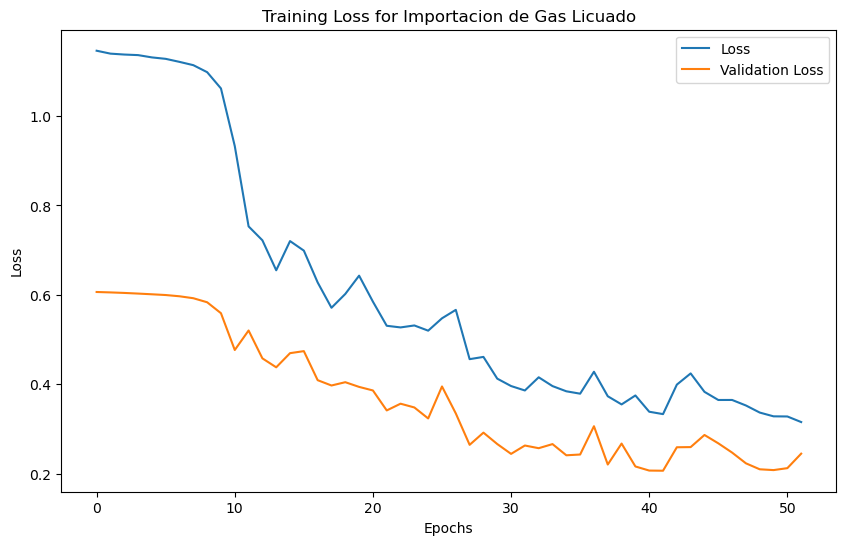

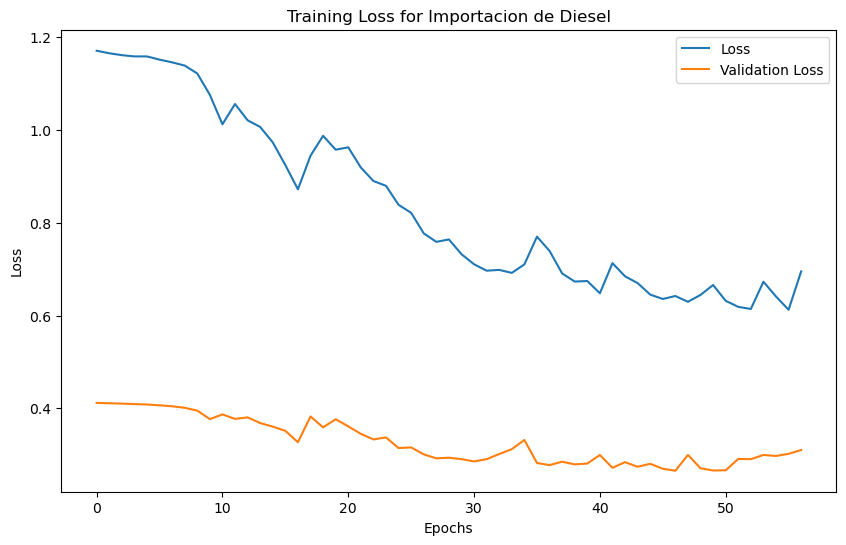

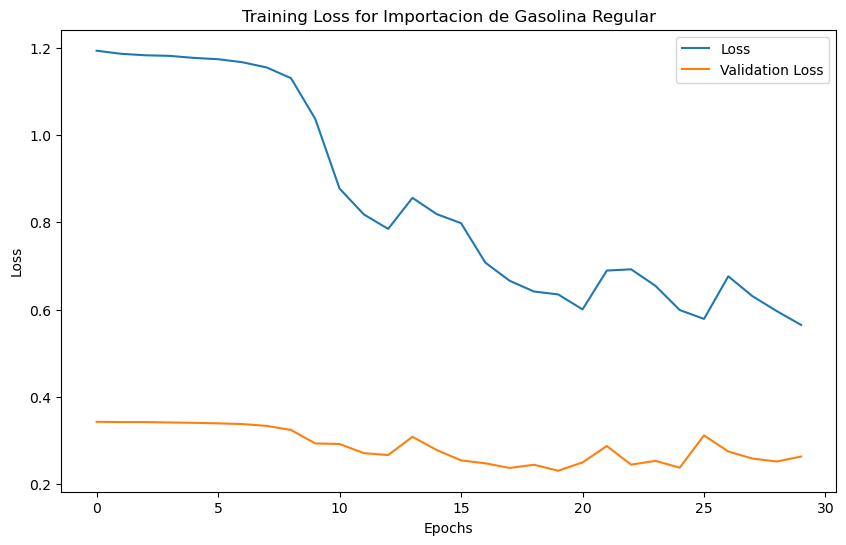

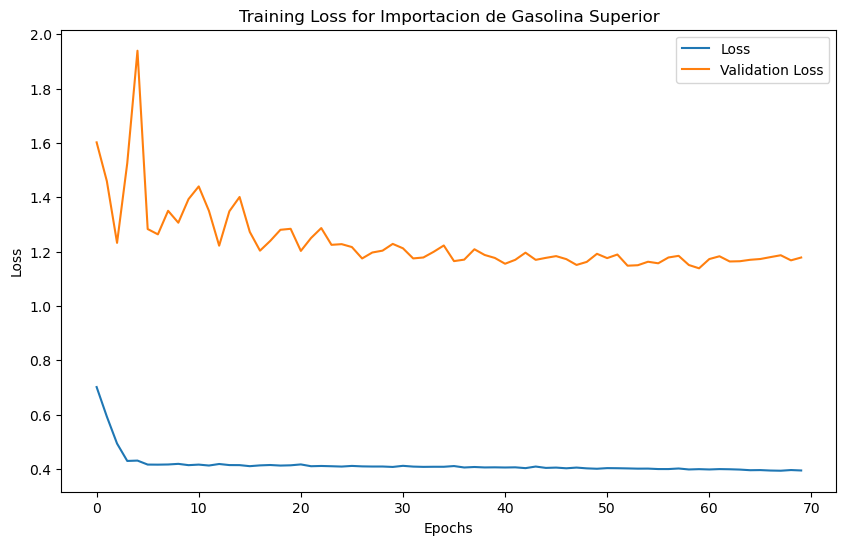

In [36]:
# Perdida Gas Licuado
plt.figure(figsize=(10, 6))
plt.plot(history_importacion_gas_licuado.history['loss'], label='Loss')
plt.plot(history_importacion_gas_licuado.history['val_loss'], label='Validation Loss')  
plt.title('Training Loss for Importacion de Gas Licuado')
plt.xlabel('Epochs')    
plt.ylabel('Loss')
plt.legend()
plt.show()

# Perdida Diesel
plt.figure(figsize=(10, 6))
plt.plot(history_importacion_diesel.history['loss'], label='Loss')
plt.plot(history_importacion_diesel.history['val_loss'], label='Validation Loss')
plt.title('Training Loss for Importacion de Diesel')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Perdida Regular
plt.figure(figsize=(10, 6))
plt.plot(history_importacion_regular.history['loss'], label='Loss')
plt.plot(history_importacion_regular.history['val_loss'], label='Validation Loss')
plt.title('Training Loss for Importacion de Gasolina Regular')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Perdida Superior
plt.figure(figsize=(10, 6))
plt.plot(history_importacion_superior.history['loss'], label='Loss')
plt.plot(history_importacion_superior.history['val_loss'], label='Validation Loss')
plt.title('Training Loss for Importacion de Gasolina Superior')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Evaluacion del Modelo
Evaluamos el modelo utilizando la métrica de Root Mean Squared Error (RMSE).

In [37]:
# Evaluacion Gas Licuado
y_pred_importacion_gas_licuado = model_importacion_gas_licuado.predict(X_test_importacion_gas_licuado)
rmse_importacion_gas_licuado = np.sqrt(mean_squared_error(y_test_importacion_gas_licuado, y_pred_importacion_gas_licuado))
print(f'RMSE for Importacion de Gas Licuado: {rmse_importacion_gas_licuado}')
print()

# Evaluacion Diesel
y_pred_importacion_diesel = model_importacion_diesel.predict(X_test_importacion_diesel)
rmse_importacion_diesel = np.sqrt(mean_squared_error(y_test_importacion_diesel, y_pred_importacion_diesel)) 
print(f'RMSE for Importacion de Diesel: {rmse_importacion_diesel}')
print()

# Evaluacion Regular
y_pred_importacion_regular = model_importacion_regular.predict(X_test_importacion_regular)
rmse_importacion_regular = np.sqrt(mean_squared_error(y_test_importacion_regular, y_pred_importacion_regular))
print(f'RMSE for Importacion de Gasolina Regular: {rmse_importacion_regular}')
print()

# Evaluacion Superior
y_pred_importacion_superior = model_importacion_superior.predict(X_test_importacion_superior)
rmse_importacion_superior = np.sqrt(mean_squared_error(y_test_importacion_superior, y_pred_importacion_superior))
print(f'RMSE for Importacion de Gasolina Superior: {rmse_importacion_superior}')

2/2 [==============================] - 0s 5ms/step
RMSE for Importacion de Gas Licuado: 0.45431032012367434

2/2 [==============================] - 0s 11ms/step
RMSE for Importacion de Diesel: 0.5153257797135377

2/2 [==============================] - 0s 6ms/step
RMSE for Importacion de Gasolina Regular: 0.4799620544646998

2/2 [==============================] - 0s 6ms/step
RMSE for Importacion de Gasolina Superior: 1.0670435249497925


#### Importacion
Aplicar el Tuneo de Parámetros a la Serie de Importacion

In [38]:
# Tuneo Gas Licuado
best_model_importacion_gas_licuado = tune_lstm_model(X_train_importacion_gas_licuado, y_train_importacion_gas_licuado, X_test_importacion_gas_licuado, y_test_importacion_gas_licuado, [50, 100], [0.001, 0.0001])

Epoch 1/50
7/7 [==============================] - 4s 102ms/step - loss: 1.1421 - val_loss: 0.6047
Epoch 2/50
7/7 [==============================] - 0s 23ms/step - loss: 1.1361 - val_loss: 0.6036
Epoch 3/50
7/7 [==============================] - 0s 23ms/step - loss: 1.1340 - val_loss: 0.6025
Epoch 4/50
7/7 [==============================] - 0s 21ms/step - loss: 1.1325 - val_loss: 0.6010
Epoch 5/50
7/7 [==============================] - 0s 21ms/step - loss: 1.1274 - val_loss: 0.5993
Epoch 6/50
7/7 [==============================] - 0s 22ms/step - loss: 1.1234 - val_loss: 0.5973
Epoch 7/50
7/7 [==============================] - 0s 22ms/step - loss: 1.1156 - val_loss: 0.5939
Epoch 8/50
7/7 [==============================] - 0s 21ms/step - loss: 1.1055 - val_loss: 0.5880
Epoch 9/50
7/7 [==============================] - 0s 29ms/step - loss: 1.0804 - val_loss: 0.5735
Epoch 10/50
7/7 [==============================] - 0s 23ms/step - loss: 0.9957 - val_loss: 0.5243
Epoch 11/50
7/7 [===========

In [39]:
# Tuneo Diesel
best_model_importacion_diesel = tune_lstm_model(X_train_importacion_diesel, y_train_importacion_diesel, X_test_importacion_diesel, y_test_importacion_diesel, [50, 100], [0.001, 0.0001])

Epoch 1/50
7/7 [==============================] - 4s 114ms/step - loss: 1.1670 - val_loss: 0.4108
Epoch 2/50
7/7 [==============================] - 0s 23ms/step - loss: 1.1628 - val_loss: 0.4098
Epoch 3/50
7/7 [==============================] - 0s 23ms/step - loss: 1.1577 - val_loss: 0.4085
Epoch 4/50
7/7 [==============================] - 0s 24ms/step - loss: 1.1537 - val_loss: 0.4073
Epoch 5/50
7/7 [==============================] - 0s 24ms/step - loss: 1.1535 - val_loss: 0.4062
Epoch 6/50
7/7 [==============================] - 0s 26ms/step - loss: 1.1448 - val_loss: 0.4039
Epoch 7/50
7/7 [==============================] - 0s 23ms/step - loss: 1.1370 - val_loss: 0.4011
Epoch 8/50
7/7 [==============================] - 0s 24ms/step - loss: 1.1263 - val_loss: 0.3960
Epoch 9/50
7/7 [==============================] - 0s 23ms/step - loss: 1.0911 - val_loss: 0.3847
Epoch 10/50
7/7 [==============================] - 0s 22ms/step - loss: 1.0283 - val_loss: 0.3595
Epoch 11/50
7/7 [===========

In [40]:
# Tuneo Regular
best_model_importacion_regular = tune_lstm_model(X_train_importacion_regular, y_train_importacion_regular, X_test_importacion_regular, y_test_importacion_regular, [50, 100], [0.001, 0.0001])

Epoch 1/50
7/7 [==============================] - 4s 99ms/step - loss: 1.1984 - val_loss: 0.3439
Epoch 2/50
7/7 [==============================] - 0s 21ms/step - loss: 1.1903 - val_loss: 0.3431
Epoch 3/50
7/7 [==============================] - 0s 22ms/step - loss: 1.1872 - val_loss: 0.3429
Epoch 4/50
7/7 [==============================] - 0s 24ms/step - loss: 1.1861 - val_loss: 0.3419
Epoch 5/50
7/7 [==============================] - 0s 23ms/step - loss: 1.1820 - val_loss: 0.3412
Epoch 6/50
7/7 [==============================] - 0s 23ms/step - loss: 1.1798 - val_loss: 0.3403
Epoch 7/50
7/7 [==============================] - 0s 23ms/step - loss: 1.1754 - val_loss: 0.3391
Epoch 8/50
7/7 [==============================] - 0s 22ms/step - loss: 1.1684 - val_loss: 0.3365
Epoch 9/50
7/7 [==============================] - 0s 23ms/step - loss: 1.1583 - val_loss: 0.3333
Epoch 10/50
7/7 [==============================] - 0s 23ms/step - loss: 1.1406 - val_loss: 0.3271
Epoch 11/50
7/7 [============

In [41]:
# Tuneo Superior
best_model_importacion_superior = tune_lstm_model(X_train_importacion_superior, y_train_importacion_superior, X_test_importacion_superior, y_test_importacion_superior, [50, 100], [0.001, 0.0001])

Epoch 1/50
7/7 [==============================] - 4s 105ms/step - loss: 0.7164 - val_loss: 1.6390
Epoch 2/50
7/7 [==============================] - 0s 33ms/step - loss: 0.6348 - val_loss: 1.5125
Epoch 3/50
7/7 [==============================] - 0s 24ms/step - loss: 0.5429 - val_loss: 1.2694
Epoch 4/50
7/7 [==============================] - 0s 22ms/step - loss: 0.4482 - val_loss: 1.7073
Epoch 5/50
7/7 [==============================] - 0s 23ms/step - loss: 0.4350 - val_loss: 2.7814
Epoch 6/50
7/7 [==============================] - 0s 22ms/step - loss: 0.4189 - val_loss: 1.3210
Epoch 7/50
7/7 [==============================] - 0s 22ms/step - loss: 0.4175 - val_loss: 1.2928
Epoch 8/50
7/7 [==============================] - 0s 22ms/step - loss: 0.4213 - val_loss: 1.4669
Epoch 9/50
7/7 [==============================] - 0s 22ms/step - loss: 0.4197 - val_loss: 1.4420
Epoch 10/50
7/7 [==============================] - 0s 23ms/step - loss: 0.4149 - val_loss: 1.5689
Epoch 11/50
7/7 [===========

## Evaluacion
Utilizamos el mejor modelo para hacer predicciones y calculamos el RMSE.

In [42]:
# Evaluacion modelo Gas Licuado
y_pred_best_importacion_gas_licuado = best_model_importacion_gas_licuado.predict(X_test_importacion_gas_licuado)
best_rmse_importacion_gas_licuado = np.sqrt(mean_squared_error(y_test_importacion_gas_licuado, y_pred_best_importacion_gas_licuado))
print(f'Best RMSE for Importación de Gas Licuado after tuning: {best_rmse_importacion_gas_licuado}')
print()

# Evaluacion modelo Diesel
y_pred_best_importacion_diesel = best_model_importacion_diesel.predict(X_test_importacion_diesel)
best_rmse_importacion_diesel = np.sqrt(mean_squared_error(y_test_importacion_diesel, y_pred_best_importacion_diesel))
print(f'Best RMSE for Importación de Diesel after tuning: {best_rmse_importacion_diesel}')
print()

# Evaluacion modelo Regular
y_pred_best_importacion_regular = best_model_importacion_regular.predict(X_test_importacion_regular)
best_rmse_importacion_regular = np.sqrt(mean_squared_error(y_test_importacion_regular, y_pred_best_importacion_regular))
print(f'Best RMSE for Importación de Gasolina Regular after tuning: {best_rmse_importacion_regular}')
print()

# Evaluacion modelo Superior
y_pred_best_importacion_superior = best_model_importacion_superior.predict(X_test_importacion_superior)
best_rmse_importacion_superior = np.sqrt(mean_squared_error(y_test_importacion_superior, y_pred_best_importacion_superior))
print(f'Best RMSE for Importación de Gasolina Superior after tuning: {best_rmse_importacion_superior}')

2/2 [==============================] - 0s 6ms/step
Best RMSE for Importación de Gas Licuado after tuning: 0.4775169786408787

2/2 [==============================] - 0s 6ms/step
Best RMSE for Importación de Diesel after tuning: 0.522698201857168

2/2 [==============================] - 0s 7ms/step
Best RMSE for Importación de Gasolina Regular after tuning: 0.4875125088111542

2/2 [==============================] - 0s 7ms/step
Best RMSE for Importación de Gasolina Superior after tuning: 1.0879316772780496


### Guardar Modelo para la Serie Importacion

In [63]:
# Guardar los modelos
best_model_importacion_gas_licuado.save('BestModels/IMPORTACION-M1/best_model_importacion_gas_licuado.h5')
best_model_importacion_diesel.save('BestModels/IMPORTACION-M1/best_model_importacion_diesel.h5')
best_model_importacion_regular.save('BestModels/IMPORTACION-M1/best_model_importacion_regular.h5')
best_model_importacion_superior.save('BestModels/IMPORTACION-M1/best_model_importacion_superior.h5')

## Modelo LSTM #2 para la serie IMPORTACION
Definimos una función para crear un modelo LSTM con una arquitectura básica.... AQUI EMPEZAR EL MODELO 2

In [49]:
# Entrenamiento Gas Licuado
model_importacion_gas_licuado2 = create_lstm_model2((X_train_importacion_gas_licuado.shape[1], X_train_importacion_gas_licuado.shape[2]))
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history_importacion_gas_licuado2 = model_importacion_gas_licuado2.fit(X_train_importacion_gas_licuado, y_train_importacion_gas_licuado, epochs=100, validation_data=(X_test_importacion_gas_licuado, y_test_importacion_gas_licuado), callbacks=[early_stopping], verbose=1)

Epoch 1/100


2024-08-11 14:44:55.247718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 6.2503

2024-08-11 14:45:04.683041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 14s 1s/step - loss: 6.2503 - val_loss: 5.7400
Epoch 2/100
7/7 [==============================] - 3s 492ms/step - loss: 5.1700 - val_loss: 5.7702
Epoch 3/100
7/7 [==============================] - 3s 498ms/step - loss: 5.2549 - val_loss: 5.7512
Epoch 4/100
7/7 [==============================] - 3s 476ms/step - loss: 4.9289 - val_loss: 5.6763
Epoch 5/100
7/7 [==============================] - 3s 473ms/step - loss: 4.6464 - val_loss: 5.6473
Epoch 6/100
7/7 [==============================] - 3s 481ms/step - loss: 4.4271 - val_loss: 5.6279
Epoch 7/100
7/7 [==============================] - 3s 475ms/step - loss: 4.5277 - val_loss: 5.5601
Epoch 8/100
7/7 [==============================] - 3s 467ms/step - loss: 4.1241 - val_loss: 5.5832
Epoch 9/100
7/7 [==============================] - 3s 475ms/step - loss: 4.0382 - val_loss: 5.5112
Epoch 10/100
7/7 [==============================] - 4s 564ms/step - loss: 4.0988 - val_loss: 5.5038
Epoch 11/100
7/7 [=====

In [50]:
# Entrenamiento Diesel
model_importacion_diesel2 = create_lstm_model2((X_train_importacion_diesel.shape[1], X_train_importacion_diesel.shape[2]))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_importacion_diesel2 = model_importacion_diesel2.fit(X_train_importacion_diesel, y_train_importacion_diesel, epochs=100, validation_data=(X_test_importacion_diesel, y_test_importacion_diesel), callbacks=[early_stopping], verbose=1)

Epoch 1/100


2024-08-11 14:51:41.072747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 6.7061

2024-08-11 14:51:49.861106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 11s 1s/step - loss: 6.7061 - val_loss: 5.6179
Epoch 2/100
7/7 [==============================] - 4s 625ms/step - loss: 5.6177 - val_loss: 5.6802
Epoch 3/100
7/7 [==============================] - 4s 582ms/step - loss: 5.2810 - val_loss: 5.6489
Epoch 4/100
7/7 [==============================] - 4s 595ms/step - loss: 4.7281 - val_loss: 5.6843
Epoch 5/100
7/7 [==============================] - 4s 534ms/step - loss: 4.7226 - val_loss: 5.6407
Epoch 6/100
7/7 [==============================] - 4s 544ms/step - loss: 4.5271 - val_loss: 5.5787
Epoch 7/100
7/7 [==============================] - 4s 533ms/step - loss: 4.4551 - val_loss: 5.5525
Epoch 8/100
7/7 [==============================] - 4s 581ms/step - loss: 4.2410 - val_loss: 5.4447
Epoch 9/100
7/7 [==============================] - 4s 546ms/step - loss: 4.1999 - val_loss: 5.3878
Epoch 10/100
7/7 [==============================] - 4s 605ms/step - loss: 4.2777 - val_loss: 5.3256
Epoch 11/100
7/7 [=====

In [54]:
# Entrenamiento Regular
model_importacion_regular2 = create_lstm_model2((X_train_importacion_regular.shape[1], X_train_importacion_regular.shape[2]))
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history_importacion_regular2 = model_importacion_regular2.fit(X_train_importacion_regular, y_train_importacion_regular, epochs=100, validation_data=(X_test_importacion_regular, y_test_importacion_regular), callbacks=[early_stopping], verbose=1)

Epoch 1/100


2024-08-11 15:17:33.887135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 5.9173

2024-08-11 15:17:43.710536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 12s 1s/step - loss: 5.9173 - val_loss: 6.5710
Epoch 2/100
7/7 [==============================] - 5s 793ms/step - loss: 4.9528 - val_loss: 6.6219
Epoch 3/100
7/7 [==============================] - 5s 734ms/step - loss: 4.4882 - val_loss: 6.6434
Epoch 4/100
7/7 [==============================] - 5s 723ms/step - loss: 4.6015 - val_loss: 6.5943
Epoch 5/100
7/7 [==============================] - 5s 718ms/step - loss: 4.2139 - val_loss: 6.5089
Epoch 6/100
7/7 [==============================] - 5s 736ms/step - loss: 4.1650 - val_loss: 6.4018
Epoch 7/100
7/7 [==============================] - 5s 779ms/step - loss: 3.9499 - val_loss: 6.3760
Epoch 8/100
7/7 [==============================] - 5s 754ms/step - loss: 3.7374 - val_loss: 6.4074
Epoch 9/100
7/7 [==============================] - 5s 752ms/step - loss: 3.7374 - val_loss: 6.3293
Epoch 10/100
7/7 [==============================] - 5s 799ms/step - loss: 3.7288 - val_loss: 6.2393
Epoch 11/100
7/7 [=====

In [52]:
# Entrenamiento Superior
model_importacion_superior2 = create_lstm_model2((X_train_importacion_superior.shape[1], X_train_importacion_superior.shape[2]))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_importacion_superior2 = model_importacion_superior2.fit(X_train_importacion_superior, y_train_importacion_superior, epochs=100, validation_data=(X_test_importacion_superior, y_test_importacion_superior), callbacks=[early_stopping], verbose=1)

Epoch 1/100


2024-08-11 15:02:35.364218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 7.3609

2024-08-11 15:02:44.999754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 12s 1s/step - loss: 7.3609 - val_loss: 5.7519
Epoch 2/100
7/7 [==============================] - 5s 709ms/step - loss: 5.4972 - val_loss: 5.8597
Epoch 3/100
7/7 [==============================] - 5s 654ms/step - loss: 5.3451 - val_loss: 5.8667
Epoch 4/100
7/7 [==============================] - 4s 653ms/step - loss: 4.7531 - val_loss: 5.8999
Epoch 5/100
7/7 [==============================] - 4s 634ms/step - loss: 4.7320 - val_loss: 5.9193
Epoch 6/100
7/7 [==============================] - 4s 644ms/step - loss: 4.6290 - val_loss: 5.9100
Epoch 7/100
7/7 [==============================] - 4s 628ms/step - loss: 4.2931 - val_loss: 5.8890
Epoch 8/100
7/7 [==============================] - 4s 649ms/step - loss: 4.2587 - val_loss: 5.8977
Epoch 9/100
7/7 [==============================] - 4s 650ms/step - loss: 4.2376 - val_loss: 5.7520
Epoch 10/100
7/7 [==============================] - 5s 663ms/step - loss: 4.0760 - val_loss: 5.6484
Epoch 11/100
7/7 [=====

### Loss for importacion serie

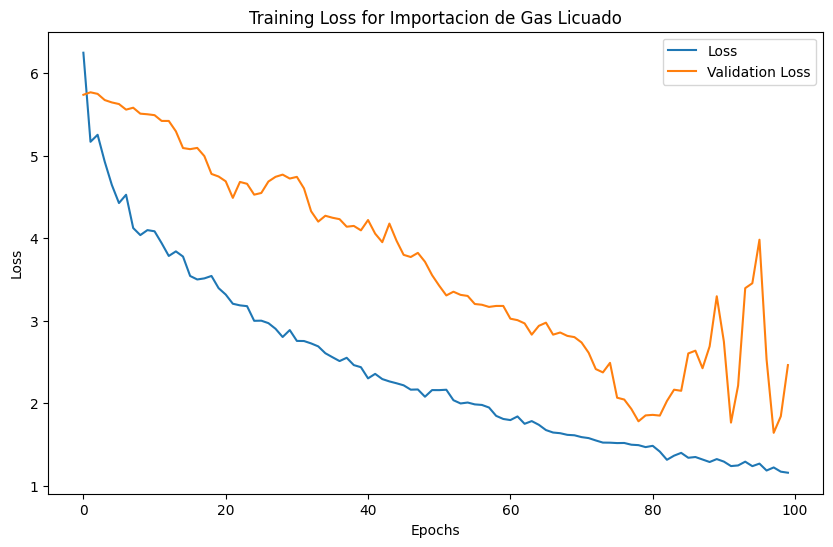

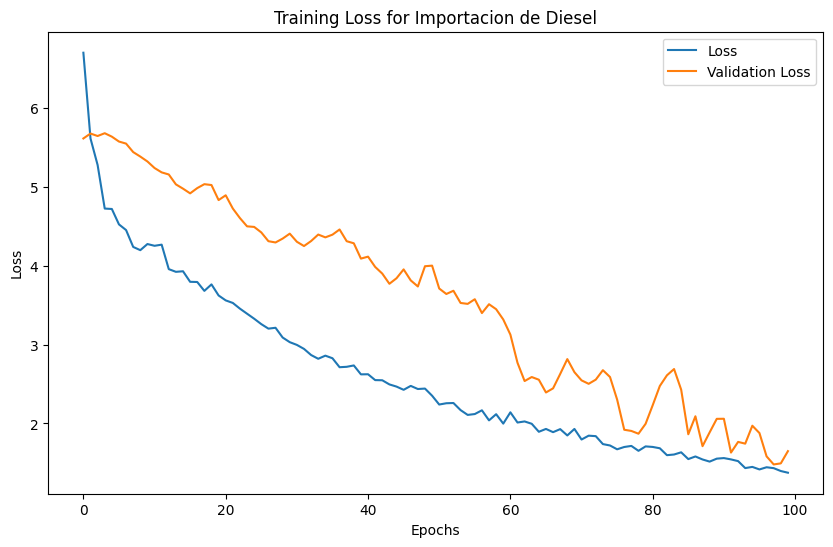

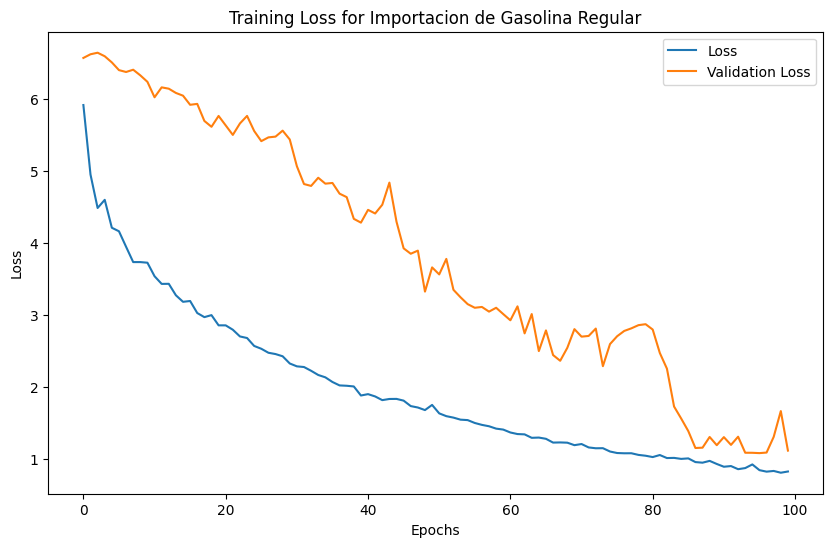

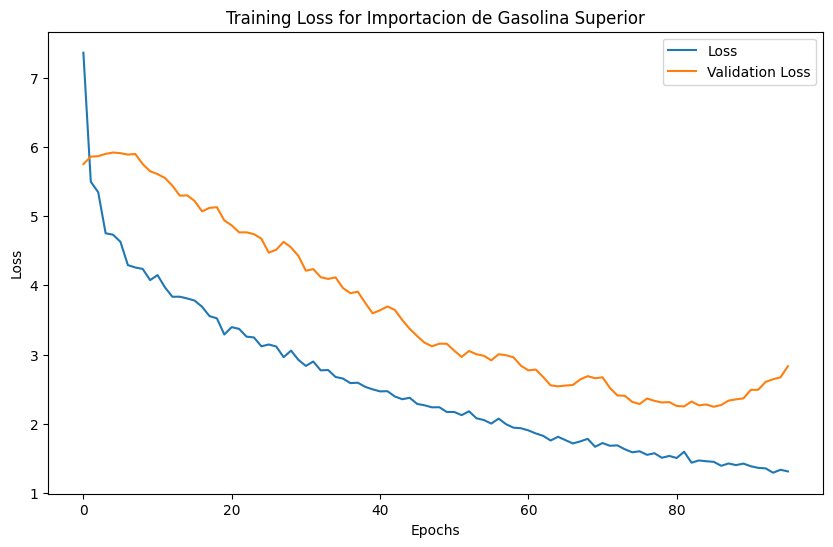

In [55]:
# Perdida Gas Licuado
plt.figure(figsize=(10, 6))
plt.plot(history_importacion_gas_licuado2.history['loss'], label='Loss')
plt.plot(history_importacion_gas_licuado2.history['val_loss'], label='Validation Loss')  
plt.title('Training Loss for Importacion de Gas Licuado')
plt.xlabel('Epochs')    
plt.ylabel('Loss')
plt.legend()
plt.show()

# Perdida Diesel
plt.figure(figsize=(10, 6))
plt.plot(history_importacion_diesel2.history['loss'], label='Loss')
plt.plot(history_importacion_diesel2.history['val_loss'], label='Validation Loss')
plt.title('Training Loss for Importacion de Diesel')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Perdida Regular
plt.figure(figsize=(10, 6))
plt.plot(history_importacion_regular2.history['loss'], label='Loss')
plt.plot(history_importacion_regular2.history['val_loss'], label='Validation Loss')
plt.title('Training Loss for Importacion de Gasolina Regular')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Perdida Superior
plt.figure(figsize=(10, 6))
plt.plot(history_importacion_superior2.history['loss'], label='Loss')
plt.plot(history_importacion_superior2.history['val_loss'], label='Validation Loss')
plt.title('Training Loss for Importacion de Gasolina Superior')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model evaluation

In [56]:
# Evaluacion Gas Licuado
y_pred_importacion_gas_licuado2 = model_importacion_gas_licuado2.predict(X_test_importacion_gas_licuado)
rmse_importacion_gas_licuado2 = np.sqrt(mean_squared_error(y_test_importacion_gas_licuado, y_pred_importacion_gas_licuado2))
print(f'RMSE for Importacion de Gas Licuado: {rmse_importacion_gas_licuado2}')
print()

# Evaluacion Diesel
y_pred_importacion_diesel2 = model_importacion_diesel2.predict(X_test_importacion_diesel)
rmse_importacion_diesel2 = np.sqrt(mean_squared_error(y_test_importacion_diesel, y_pred_importacion_diesel2)) 
print(f'RMSE for Importacion de Diesel: {rmse_importacion_diesel2}')
print()

# Evaluacion Regular
y_pred_importacion_regular2 = model_importacion_regular2.predict(X_test_importacion_regular)
rmse_importacion_regular2 = np.sqrt(mean_squared_error(y_test_importacion_regular, y_pred_importacion_regular2))
print(f'RMSE for Importacion de Gasolina Regular: {rmse_importacion_regular2}')
print()

# Evaluacion Superior
y_pred_importacion_superior2 = model_importacion_superior2.predict(X_test_importacion_superior)
rmse_importacion_superior2 = np.sqrt(mean_squared_error(y_test_importacion_superior, y_pred_importacion_superior2))
print(f'RMSE for Importacion de Gasolina Superior: {rmse_importacion_superior2}')

2024-08-11 15:33:55.452952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 434ms/step
RMSE for Importacion de Gas Licuado: 1.2920487182949716



2024-08-11 15:33:56.814887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 398ms/step
RMSE for Importacion de Diesel: 0.8773310161544582



2024-08-11 15:33:57.988847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 396ms/step
RMSE for Importacion de Gasolina Regular: 0.6982865184247452



2024-08-11 15:34:00.079006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 483ms/step
RMSE for Importacion de Gasolina Superior: 1.118718016647984


### Hyper param tunning for imports

In [57]:
# Tuneo Gas Licuado
best_model_importacion_gas_licuado2 = tune_lstm_model2(X_train_importacion_gas_licuado, y_train_importacion_gas_licuado, X_test_importacion_gas_licuado, y_test_importacion_gas_licuado, [50, 100], [0.001, 0.0001])

Epoch 1/50


2024-08-11 15:35:34.339062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 4.3731

2024-08-11 15:35:43.317322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 12s 1s/step - loss: 4.3731 - val_loss: 4.0151
Epoch 2/50
7/7 [==============================] - 5s 676ms/step - loss: 3.3790 - val_loss: 4.1647
Epoch 3/50
7/7 [==============================] - 4s 616ms/step - loss: 3.2848 - val_loss: 4.3109
Epoch 4/50
7/7 [==============================] - 4s 557ms/step - loss: 3.1194 - val_loss: 4.3954
Epoch 5/50
7/7 [==============================] - 4s 570ms/step - loss: 3.0078 - val_loss: 4.4131
Epoch 6/50
7/7 [==============================] - 4s 561ms/step - loss: 2.8164 - val_loss: 4.4740
Epoch 7/50
7/7 [==============================] - 4s 560ms/step - loss: 2.6560 - val_loss: 4.5097
Epoch 8/50
7/7 [==============================] - 4s 578ms/step - loss: 2.6506 - val_loss: 4.4359
Epoch 9/50
7/7 [==============================] - 4s 601ms/step - loss: 2.4870 - val_loss: 4.3185
Epoch 10/50
7/7 [==============================] - 4s 583ms/step - loss: 2.4612 - val_loss: 4.3693
Epoch 11/50
7/7 [===============

2024-08-11 15:36:25.562200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 385ms/step


Epoch 1/50


2024-08-11 15:36:27.580674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 4.1914

2024-08-11 15:36:36.676288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 11s 1s/step - loss: 4.1914 - val_loss: 3.9244
Epoch 2/50
7/7 [==============================] - 5s 762ms/step - loss: 4.0148 - val_loss: 4.0124
Epoch 3/50
7/7 [==============================] - 5s 759ms/step - loss: 3.6862 - val_loss: 4.0969
Epoch 4/50
7/7 [==============================] - 5s 774ms/step - loss: 3.6071 - val_loss: 4.1724
Epoch 5/50
7/7 [==============================] - 5s 800ms/step - loss: 3.3440 - val_loss: 4.2444
Epoch 6/50
7/7 [==============================] - 6s 820ms/step - loss: 3.3665 - val_loss: 4.3184
Epoch 7/50
7/7 [==============================] - 6s 855ms/step - loss: 3.3268 - val_loss: 4.3871
Epoch 8/50
7/7 [==============================] - 6s 891ms/step - loss: 3.4925 - val_loss: 4.4599
Epoch 9/50
7/7 [==============================] - 6s 920ms/step - loss: 3.3160 - val_loss: 4.5283
Epoch 10/50
7/7 [==============================] - 6s 941ms/step - loss: 3.2807 - val_loss: 4.5931
Epoch 11/50
7/7 [===============

2024-08-11 15:37:36.256369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 439ms/step


Epoch 1/50


2024-08-11 15:37:38.653855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 6.9348

2024-08-11 15:37:52.286475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 16s 2s/step - loss: 6.9348 - val_loss: 5.7873
Epoch 2/50
7/7 [==============================] - 9s 1s/step - loss: 5.1843 - val_loss: 5.9540
Epoch 3/50
7/7 [==============================] - 9s 1s/step - loss: 5.1047 - val_loss: 6.0728
Epoch 4/50
7/7 [==============================] - 9s 1s/step - loss: 4.7873 - val_loss: 6.1791
Epoch 5/50
7/7 [==============================] - 8s 1s/step - loss: 4.5754 - val_loss: 6.1602
Epoch 6/50
7/7 [==============================] - 9s 1s/step - loss: 4.3792 - val_loss: 6.1527
Epoch 7/50
7/7 [==============================] - 9s 1s/step - loss: 4.2486 - val_loss: 6.0834
Epoch 8/50
7/7 [==============================] - 9s 1s/step - loss: 4.1959 - val_loss: 6.0095
Epoch 9/50
7/7 [==============================] - 9s 1s/step - loss: 4.1132 - val_loss: 6.0120
Epoch 10/50
7/7 [==============================] - 9s 1s/step - loss: 4.1017 - val_loss: 5.9158
Epoch 11/50
7/7 [==============================] - 9s 1s/st

2024-08-11 15:39:21.141098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 487ms/step


Epoch 1/50


2024-08-11 15:39:23.974892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 6.6202

2024-08-11 15:39:38.748382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 18s 2s/step - loss: 6.6202 - val_loss: 5.7759
Epoch 2/50
7/7 [==============================] - 9s 1s/step - loss: 6.2583 - val_loss: 5.8859
Epoch 3/50
7/7 [==============================] - 9s 1s/step - loss: 6.0925 - val_loss: 5.9928
Epoch 4/50
7/7 [==============================] - 8s 1s/step - loss: 5.7445 - val_loss: 6.0987
Epoch 5/50
7/7 [==============================] - 8s 1s/step - loss: 5.6388 - val_loss: 6.1833
Epoch 6/50
7/7 [==============================] - 8s 1s/step - loss: 5.3601 - val_loss: 6.2660
Epoch 7/50
7/7 [==============================] - 8s 1s/step - loss: 5.2044 - val_loss: 6.3487
Epoch 8/50
7/7 [==============================] - 8s 1s/step - loss: 5.1515 - val_loss: 6.4357
Epoch 9/50
7/7 [==============================] - 8s 1s/step - loss: 4.8850 - val_loss: 6.5174
Epoch 10/50
7/7 [==============================] - 8s 1s/step - loss: 4.8334 - val_loss: 6.5896
Epoch 11/50
7/7 [==============================] - 9s 1s/st

2024-08-11 15:41:04.892141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 496ms/step


In [58]:
# Tuneo Diesel
best_model_importacion_diesel2 = tune_lstm_model2(X_train_importacion_diesel, y_train_importacion_diesel, X_test_importacion_diesel, y_test_importacion_diesel, [50, 100], [0.001, 0.0001])

Epoch 1/50


2024-08-11 15:45:25.597371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 4.4763

2024-08-11 15:45:33.975759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 12s 965ms/step - loss: 4.4763 - val_loss: 3.8260
Epoch 2/50
7/7 [==============================] - 4s 515ms/step - loss: 3.7448 - val_loss: 3.8407
Epoch 3/50
7/7 [==============================] - 3s 487ms/step - loss: 3.4821 - val_loss: 3.8449
Epoch 4/50
7/7 [==============================] - 3s 483ms/step - loss: 3.2956 - val_loss: 3.8731
Epoch 5/50
7/7 [==============================] - 3s 477ms/step - loss: 2.9496 - val_loss: 3.8314
Epoch 6/50
7/7 [==============================] - 3s 483ms/step - loss: 2.7971 - val_loss: 3.7900
Epoch 7/50
7/7 [==============================] - 3s 472ms/step - loss: 2.9134 - val_loss: 3.7471
Epoch 8/50
7/7 [==============================] - 3s 477ms/step - loss: 2.8366 - val_loss: 3.7369
Epoch 9/50
7/7 [==============================] - 3s 475ms/step - loss: 2.5931 - val_loss: 3.7633
Epoch 10/50
7/7 [==============================] - 3s 471ms/step - loss: 2.7927 - val_loss: 3.7559
Epoch 11/50
7/7 [============

2024-08-11 15:49:34.768133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 525ms/step


Epoch 1/50


2024-08-11 15:49:37.935700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 3.6885

2024-08-11 15:49:52.565576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 18s 2s/step - loss: 3.6885 - val_loss: 3.8449
Epoch 2/50
7/7 [==============================] - 9s 1s/step - loss: 3.7347 - val_loss: 3.8843
Epoch 3/50
7/7 [==============================] - 8s 1s/step - loss: 3.5222 - val_loss: 3.9212
Epoch 4/50
7/7 [==============================] - 7s 1s/step - loss: 3.4288 - val_loss: 3.9533
Epoch 5/50
7/7 [==============================] - 8s 1s/step - loss: 3.4915 - val_loss: 3.9794
Epoch 6/50
7/7 [==============================] - 8s 1s/step - loss: 3.4827 - val_loss: 4.0157
Epoch 7/50
7/7 [==============================] - 7s 1s/step - loss: 3.1493 - val_loss: 4.0465
Epoch 8/50
7/7 [==============================] - 7s 1s/step - loss: 3.3112 - val_loss: 4.0734
Epoch 9/50
7/7 [==============================] - 8s 1s/step - loss: 3.1801 - val_loss: 4.1057
Epoch 10/50
7/7 [==============================] - 8s 1s/step - loss: 3.1751 - val_loss: 4.1349
Epoch 11/50
7/7 [==============================] - 8s 1s/st

2024-08-11 15:51:11.799972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 491ms/step


Epoch 1/50


2024-08-11 15:51:14.825944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 6.1146

2024-08-11 15:51:28.814752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 17s 2s/step - loss: 6.1146 - val_loss: 5.7210
Epoch 2/50
7/7 [==============================] - 9s 1s/step - loss: 5.3601 - val_loss: 5.8291
Epoch 3/50
7/7 [==============================] - 8s 1s/step - loss: 4.8880 - val_loss: 5.8542
Epoch 4/50
7/7 [==============================] - 8s 1s/step - loss: 4.9280 - val_loss: 5.8312
Epoch 5/50
7/7 [==============================] - 8s 1s/step - loss: 4.9368 - val_loss: 5.7269
Epoch 6/50
7/7 [==============================] - 8s 1s/step - loss: 4.6574 - val_loss: 5.6588
Epoch 7/50
7/7 [==============================] - 8s 1s/step - loss: 4.4693 - val_loss: 5.7398
Epoch 8/50
7/7 [==============================] - 8s 1s/step - loss: 4.3465 - val_loss: 5.6910
Epoch 9/50
7/7 [==============================] - 10s 1s/step - loss: 4.2363 - val_loss: 5.6281
Epoch 10/50
7/7 [==============================] - 9s 1s/step - loss: 4.2313 - val_loss: 5.5693
Epoch 11/50
7/7 [==============================] - 9s 1s/s

2024-08-11 15:59:01.464128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 579ms/step


Epoch 1/50


2024-08-11 15:59:04.940071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 7.4901

2024-08-11 15:59:22.302352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 22s 2s/step - loss: 7.4901 - val_loss: 5.5177
Epoch 2/50
7/7 [==============================] - 11s 2s/step - loss: 6.6094 - val_loss: 5.4658
Epoch 3/50
7/7 [==============================] - 11s 2s/step - loss: 6.5464 - val_loss: 5.4249
Epoch 4/50
7/7 [==============================] - 12s 2s/step - loss: 6.4058 - val_loss: 5.3890
Epoch 5/50
7/7 [==============================] - 10s 1s/step - loss: 5.7101 - val_loss: 5.3546
Epoch 6/50
7/7 [==============================] - 10s 1s/step - loss: 5.7665 - val_loss: 5.3236
Epoch 7/50
7/7 [==============================] - 10s 1s/step - loss: 5.5771 - val_loss: 5.2896
Epoch 8/50
7/7 [==============================] - 9s 1s/step - loss: 5.1758 - val_loss: 5.2606
Epoch 9/50
7/7 [==============================] - 9s 1s/step - loss: 5.1637 - val_loss: 5.2364
Epoch 10/50
7/7 [==============================] - 10s 1s/step - loss: 5.5284 - val_loss: 5.2143
Epoch 11/50
7/7 [==============================] - 1

2024-08-11 16:07:18.645400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 3s 942ms/step


In [59]:
# Tuneo Regular
best_model_importacion_regular2 = tune_lstm_model2(X_train_importacion_regular, y_train_importacion_regular, X_test_importacion_regular, y_test_importacion_regular, [50, 100], [0.001, 0.0001])

Epoch 1/50


2024-08-11 16:08:00.037519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 3.8058

2024-08-11 16:08:15.869496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 19s 2s/step - loss: 3.8058 - val_loss: 4.8653
Epoch 2/50
7/7 [==============================] - 9s 1s/step - loss: 3.1153 - val_loss: 5.1163
Epoch 3/50
7/7 [==============================] - 7s 991ms/step - loss: 2.9110 - val_loss: 5.2943
Epoch 4/50
7/7 [==============================] - 6s 949ms/step - loss: 2.6703 - val_loss: 5.4200
Epoch 5/50
7/7 [==============================] - 7s 970ms/step - loss: 2.4517 - val_loss: 5.4739
Epoch 6/50
7/7 [==============================] - 8s 1s/step - loss: 2.3711 - val_loss: 5.5215
Epoch 7/50
7/7 [==============================] - 7s 992ms/step - loss: 2.3196 - val_loss: 5.5159
Epoch 8/50
7/7 [==============================] - 7s 982ms/step - loss: 2.3232 - val_loss: 5.4881
Epoch 9/50
7/7 [==============================] - 7s 1s/step - loss: 2.1462 - val_loss: 5.4889
Epoch 10/50
7/7 [==============================] - 7s 1s/step - loss: 2.2448 - val_loss: 5.4321
Epoch 11/50
7/7 [===========================

2024-08-11 16:09:30.712518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 733ms/step


Epoch 1/50


2024-08-11 16:09:33.928161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 4.5326

2024-08-11 16:09:52.120880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 22s 2s/step - loss: 4.5326 - val_loss: 4.9059
Epoch 2/50
7/7 [==============================] - 11s 2s/step - loss: 4.7497 - val_loss: 5.1514
Epoch 3/50
7/7 [==============================] - 11s 2s/step - loss: 3.8158 - val_loss: 5.3786
Epoch 4/50
7/7 [==============================] - 9s 1s/step - loss: 3.6725 - val_loss: 5.5888
Epoch 5/50
7/7 [==============================] - 10s 1s/step - loss: 3.6220 - val_loss: 5.7833
Epoch 6/50
7/7 [==============================] - 10s 1s/step - loss: 3.7540 - val_loss: 5.9846
Epoch 7/50
7/7 [==============================] - 11s 2s/step - loss: 3.3734 - val_loss: 6.1760
Epoch 8/50
7/7 [==============================] - 10s 2s/step - loss: 3.1507 - val_loss: 6.3581
Epoch 9/50
7/7 [==============================] - 10s 1s/step - loss: 3.2637 - val_loss: 6.5315
Epoch 10/50
7/7 [==============================] - 9s 1s/step - loss: 3.2548 - val_loss: 6.7036
Epoch 11/50
7/7 [==============================] - 1

2024-08-11 16:11:35.685778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 3s 1s/step


Epoch 1/50


2024-08-11 16:11:42.708441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 5.9284

2024-08-11 16:12:03.240632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 28s 3s/step - loss: 5.9284 - val_loss: 6.7578
Epoch 2/50
7/7 [==============================] - 11s 2s/step - loss: 4.7990 - val_loss: 6.9978
Epoch 3/50
7/7 [==============================] - 10s 1s/step - loss: 4.6825 - val_loss: 7.1261
Epoch 4/50
7/7 [==============================] - 13s 2s/step - loss: 4.3306 - val_loss: 7.1538
Epoch 5/50
7/7 [==============================] - 10s 1s/step - loss: 4.1303 - val_loss: 7.1275
Epoch 6/50
7/7 [==============================] - 9s 1s/step - loss: 4.1625 - val_loss: 7.1763
Epoch 7/50
7/7 [==============================] - 9s 1s/step - loss: 4.1109 - val_loss: 7.0822
Epoch 8/50
7/7 [==============================] - 9s 1s/step - loss: 3.8210 - val_loss: 7.1077
Epoch 9/50
7/7 [==============================] - 9s 1s/step - loss: 3.8487 - val_loss: 6.9711
Epoch 10/50
7/7 [==============================] - 11s 2s/step - loss: 3.7577 - val_loss: 6.9779
Epoch 11/50
7/7 [==============================] - 13s

2024-08-11 16:13:52.558142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 3s 1s/step


Epoch 1/50


2024-08-11 16:13:57.966041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 7.1895

2024-08-11 16:14:24.492054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 35s 4s/step - loss: 7.1895 - val_loss: 6.5267
Epoch 2/50
7/7 [==============================] - 13s 2s/step - loss: 6.3045 - val_loss: 6.5290
Epoch 3/50
7/7 [==============================] - 10s 1s/step - loss: 5.6482 - val_loss: 6.5426
Epoch 4/50
7/7 [==============================] - 14s 2s/step - loss: 5.4361 - val_loss: 6.5632
Epoch 5/50
7/7 [==============================] - 10s 1s/step - loss: 5.8149 - val_loss: 6.5706
Epoch 6/50
7/7 [==============================] - 10s 1s/step - loss: 4.8487 - val_loss: 6.5814
Epoch 7/50
7/7 [==============================] - 9s 1s/step - loss: 4.8991 - val_loss: 6.5792
Epoch 8/50
7/7 [==============================] - 13s 2s/step - loss: 4.9322 - val_loss: 6.5727
Epoch 9/50
7/7 [==============================] - 12s 2s/step - loss: 4.8913 - val_loss: 6.5746
Epoch 10/50
7/7 [==============================] - 14s 2s/step - loss: 4.6100 - val_loss: 6.5695
Epoch 11/50
7/7 [==============================] - 

2024-08-11 16:16:29.337066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 3s 1s/step


In [60]:
# Tuneo Superior
best_model_importacion_superior2 = tune_lstm_model2(X_train_importacion_superior, y_train_importacion_superior, X_test_importacion_superior, y_test_importacion_superior, [50, 100], [0.001, 0.0001])

Epoch 1/50


2024-08-11 16:25:26.583606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 4.6948

2024-08-11 16:25:37.777567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 14s 1s/step - loss: 4.6948 - val_loss: 3.9711
Epoch 2/50
7/7 [==============================] - 4s 606ms/step - loss: 3.6520 - val_loss: 4.0312
Epoch 3/50
7/7 [==============================] - 4s 552ms/step - loss: 3.2734 - val_loss: 4.0386
Epoch 4/50
7/7 [==============================] - 4s 537ms/step - loss: 3.1398 - val_loss: 4.0870
Epoch 5/50
7/7 [==============================] - 4s 537ms/step - loss: 2.8284 - val_loss: 4.1086
Epoch 6/50
7/7 [==============================] - 4s 527ms/step - loss: 2.6785 - val_loss: 4.1131
Epoch 7/50
7/7 [==============================] - 4s 522ms/step - loss: 2.7718 - val_loss: 4.0874
Epoch 8/50
7/7 [==============================] - 4s 513ms/step - loss: 2.6344 - val_loss: 4.0880
Epoch 9/50
7/7 [==============================] - 4s 568ms/step - loss: 2.5959 - val_loss: 4.0916
Epoch 10/50
7/7 [==============================] - 4s 539ms/step - loss: 2.5680 - val_loss: 4.0982
Epoch 11/50
7/7 [===============

2024-08-11 16:26:17.514896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 716ms/step


Epoch 1/50


2024-08-11 16:26:20.282778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 4.7037

2024-08-11 16:26:32.136744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 15s 1s/step - loss: 4.7037 - val_loss: 3.9713
Epoch 2/50
7/7 [==============================] - 5s 654ms/step - loss: 3.9855 - val_loss: 4.0252
Epoch 3/50
7/7 [==============================] - 4s 552ms/step - loss: 3.6162 - val_loss: 4.0719
Epoch 4/50
7/7 [==============================] - 4s 533ms/step - loss: 4.1607 - val_loss: 4.1191
Epoch 5/50
7/7 [==============================] - 4s 520ms/step - loss: 3.8207 - val_loss: 4.1658
Epoch 6/50
7/7 [==============================] - 4s 526ms/step - loss: 3.7122 - val_loss: 4.2036
Epoch 7/50
7/7 [==============================] - 4s 532ms/step - loss: 3.4263 - val_loss: 4.2438
Epoch 8/50
7/7 [==============================] - 4s 531ms/step - loss: 3.4762 - val_loss: 4.2808
Epoch 9/50
7/7 [==============================] - 4s 549ms/step - loss: 3.4532 - val_loss: 4.3147
Epoch 10/50
7/7 [==============================] - 4s 552ms/step - loss: 3.5053 - val_loss: 4.3441
Epoch 11/50
7/7 [===============

2024-08-11 16:27:12.421464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 698ms/step


Epoch 1/50


2024-08-11 16:27:15.198959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 6.5352

2024-08-11 16:27:26.693346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 15s 1s/step - loss: 6.5352 - val_loss: 5.7337
Epoch 2/50
7/7 [==============================] - 4s 581ms/step - loss: 5.7700 - val_loss: 5.8383
Epoch 3/50
7/7 [==============================] - 4s 558ms/step - loss: 5.1643 - val_loss: 5.8763
Epoch 4/50
7/7 [==============================] - 4s 578ms/step - loss: 5.0983 - val_loss: 5.8976
Epoch 5/50
7/7 [==============================] - 4s 626ms/step - loss: 4.8482 - val_loss: 5.8922
Epoch 6/50
7/7 [==============================] - 4s 609ms/step - loss: 4.6661 - val_loss: 5.8948
Epoch 7/50
7/7 [==============================] - 5s 682ms/step - loss: 4.4220 - val_loss: 5.8725
Epoch 8/50
7/7 [==============================] - 5s 723ms/step - loss: 4.4129 - val_loss: 5.8747
Epoch 9/50
7/7 [==============================] - 8s 1s/step - loss: 4.2423 - val_loss: 5.7436
Epoch 10/50
7/7 [==============================] - 6s 875ms/step - loss: 4.1191 - val_loss: 5.6321
Epoch 11/50
7/7 [==================

2024-08-11 16:32:32.093512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 816ms/step


Epoch 1/50


2024-08-11 16:32:35.387304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 6.9437

2024-08-11 16:32:54.830535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 23s 3s/step - loss: 6.9437 - val_loss: 5.6650
Epoch 2/50
7/7 [==============================] - 14s 2s/step - loss: 6.0974 - val_loss: 5.6067
Epoch 3/50
7/7 [==============================] - 14s 2s/step - loss: 6.1945 - val_loss: 5.5480
Epoch 4/50
7/7 [==============================] - 12s 2s/step - loss: 5.5178 - val_loss: 5.4971
Epoch 5/50
7/7 [==============================] - 11s 2s/step - loss: 5.3660 - val_loss: 5.4501
Epoch 6/50
7/7 [==============================] - 10s 1s/step - loss: 5.1513 - val_loss: 5.4106
Epoch 7/50
7/7 [==============================] - 10s 1s/step - loss: 5.0245 - val_loss: 5.3670
Epoch 8/50
7/7 [==============================] - 9s 1s/step - loss: 4.9873 - val_loss: 5.3259
Epoch 9/50
7/7 [==============================] - 9s 1s/step - loss: 4.9147 - val_loss: 5.2943
Epoch 10/50
7/7 [==============================] - 10s 1s/step - loss: 4.8255 - val_loss: 5.2630
Epoch 11/50
7/7 [==============================] - 1

2024-08-11 16:41:29.383304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 3s 1s/step


### Evaluation

In [62]:
# Evaluacion modelo Gas Licuado
y_pred_best_importacion_gas_licuado2 = best_model_importacion_gas_licuado2.predict(X_test_importacion_gas_licuado)
best_rmse_importacion_gas_licuado2 = np.sqrt(mean_squared_error(y_test_importacion_gas_licuado, y_pred_best_importacion_gas_licuado2))
print(f'Best RMSE for Importación de Gas Licuado after tuning: {best_rmse_importacion_gas_licuado2}')
print()

# Evaluacion modelo Diesel
y_pred_best_importacion_diesel2 = best_model_importacion_diesel2.predict(X_test_importacion_diesel)
best_rmse_importacion_diesel2 = np.sqrt(mean_squared_error(y_test_importacion_diesel, y_pred_best_importacion_diesel2))
print(f'Best RMSE for Importación de Diesel after tuning: {best_rmse_importacion_diesel2}')
print()

# Evaluacion modelo Regular
y_pred_best_importacion_regular2 = best_model_importacion_regular2.predict(X_test_importacion_regular)
best_rmse_importacion_regular2 = np.sqrt(mean_squared_error(y_test_importacion_regular, y_pred_best_importacion_regular2))
print(f'Best RMSE for Importación de Gasolina Regular after tuning: {best_rmse_importacion_regular2}')
print()

# Evaluacion modelo Superior
y_pred_best_importacion_superior2 = best_model_importacion_superior2.predict(X_test_importacion_superior)
best_rmse_importacion_superior2 = np.sqrt(mean_squared_error(y_test_importacion_superior, y_pred_best_importacion_superior2))
print(f'Best RMSE for Importación de Gasolina Superior after tuning: {best_rmse_importacion_superior2}')

2/2 [==============================] - 0s 86ms/step
Best RMSE for Importación de Gas Licuado after tuning: 1.3465367689507688

2/2 [==============================] - 0s 99ms/step
Best RMSE for Importación de Diesel after tuning: 0.7991956779401179

2/2 [==============================] - 0s 97ms/step
Best RMSE for Importación de Gasolina Regular after tuning: 1.6217562310769014

2/2 [==============================] - 0s 104ms/step
Best RMSE for Importación de Gasolina Superior after tuning: 1.0701198691357507


### Guardar modelos para serie de importaciones

In [64]:
# Guardar los modelos
model_importacion_gas_licuado2.save('BestModels/IMPORTACION-M2/best_model_importacion_gas_licuado.h5')
best_model_importacion_diesel2.save('BestModels/IMPORTACION-M2/best_model_importacion_diesel.h5')
model_importacion_regular2.save('BestModels/IMPORTACION-M2/best_model_importacion_regular.h5')
best_model_importacion_superior2.save('BestModels/IMPORTACION-M2/best_model_importacion_superior.h5')

# SERIE PRECIOS

### Division de conjunto de datos
Dividimos los datos en conjuntos de entrenamiento (80%) y prueba (20%).

In [43]:
# Division de los datos de precios
train_size = int(len(X_precios_gas_licuado) * 0.8)

# Gas Licuado
X_train_precios_gas_licuado, X_test_precios_gas_licuado = X_precios_gas_licuado[:train_size], X_precios_gas_licuado[train_size:]
y_train_precios_gas_licuado, y_test_precios_gas_licuado = y_precios_gas_licuado[:train_size], y_precios_gas_licuado[train_size:]

# Diesel
X_train_precios_diesel, X_test_precios_diesel = X_precios_diesel[:train_size], X_precios_diesel[train_size:]
y_train_precios_diesel, y_test_precios_diesel = y_precios_diesel[:train_size], y_precios_diesel[train_size:]

# Regular
X_train_precios_regular, X_test_precios_regular = X_precios_regular[:train_size], X_precios_regular[train_size:]
y_train_precios_regular, y_test_precios_regular = y_precios_regular[:train_size], y_precios_regular[train_size:]

# Superior
X_train_precios_superior, X_test_precios_superior = X_precios_superior[:train_size], X_precios_superior[train_size:]
y_train_precios_superior, y_test_precios_superior = y_precios_superior[:train_size], y_precios_superior[train_size:]

#### Entrenamiento para todos los combustibles
Entrenamos el modelo LSTM usando los datos de importacion.

In [44]:
# ya que el array es en 2D ajustamos la forma para que sea compatible con el modelo LSTM

# Precios Gas Licuado
if len(X_train_precios_gas_licuado.shape) == 2:
    X_train_precios_gas_licuado = np.expand_dims(X_train_precios_gas_licuado, axis=-1)
    X_test_precios_gas_licuado = np.expand_dims(X_test_precios_gas_licuado, axis=-1)

print(f"Nuevas dimensiones de X_train_precios_gas_licuado: {X_train_precios_gas_licuado.shape}")

# Precios Diesel
if len(X_train_precios_diesel.shape) == 2:
    X_train_precios_diesel = np.expand_dims(X_train_precios_diesel, axis=-1)
    X_test_precios_diesel = np.expand_dims(X_test_precios_diesel, axis=-1)

print(f"Nuevas dimensiones de X_train_precios_diesel: {X_train_precios_diesel.shape}")

# Precios Regular
if len(X_train_precios_regular.shape) == 2:
    X_train_precios_regular = np.expand_dims(X_train_precios_regular, axis=-1)
    X_test_precios_regular = np.expand_dims(X_test_precios_regular, axis=-1)

print(f"Nuevas dimensiones de X_train_precios_regular: {X_train_precios_regular.shape}")

# Precios Superior
if len(X_train_precios_superior.shape) == 2:
    X_train_precios_superior = np.expand_dims(X_train_precios_superior, axis=-1)
    X_test_precios_superior = np.expand_dims(X_test_precios_superior, axis=-1)

print(f"Nuevas dimensiones de X_train_precios_superior: {X_train_precios_superior.shape}")

Nuevas dimensiones de X_train_precios_gas_licuado: (25, 12, 1)
Nuevas dimensiones de X_train_precios_diesel: (25, 12, 1)
Nuevas dimensiones de X_train_precios_regular: (25, 12, 1)
Nuevas dimensiones de X_train_precios_superior: (25, 12, 1)


In [50]:
# Entrenamiento Gas Licuado
model_precios_gas_licuado = create_lstm_model((X_train_precios_gas_licuado.shape[1], X_train_precios_gas_licuado.shape[2]))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_precios_gas_licuado = model_precios_gas_licuado.fit(X_train_precios_gas_licuado, y_train_precios_gas_licuado, epochs=100, validation_data=(X_test_precios_gas_licuado, y_test_precios_gas_licuado), callbacks=[early_stopping], verbose=1)

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 1.0157 - val_loss: 1.0025
Epoch 2/100
1/1 [==============================] - 0s 60ms/step - loss: 1.0058 - val_loss: 1.0308
Epoch 3/100
1/1 [==============================] - 0s 61ms/step - loss: 0.9960 - val_loss: 1.0598
Epoch 4/100
1/1 [==============================] - 0s 61ms/step - loss: 0.9863 - val_loss: 1.0905
Epoch 5/100
1/1 [==============================] - 0s 60ms/step - loss: 0.9766 - val_loss: 1.1219
Epoch 6/100
1/1 [==============================] - 0s 67ms/step - loss: 0.9671 - val_loss: 1.1543
Epoch 7/100
1/1 [==============================] - 0s 58ms/step - loss: 0.9574 - val_loss: 1.1900
Epoch 8/100
1/1 [==============================] - 0s 64ms/step - loss: 0.9477 - val_loss: 1.2285
Epoch 9/100
1/1 [==============================] - 0s 66ms/step - loss: 0.9382 - val_loss: 1.2696
Epoch 10/100
1/1 [==============================] - 0s 65ms/step - loss: 0.9286 - val_loss: 1.3131
Epoch 11/100
1/1 [===

In [51]:
# Entrenamiento Diesel
model_precios_diesel = create_lstm_model((X_train_precios_diesel.shape[1], X_train_precios_diesel.shape[2]))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_precios_diesel = model_precios_diesel.fit(X_train_precios_diesel, y_train_precios_diesel, epochs=100, validation_data=(X_test_precios_diesel, y_test_precios_diesel), callbacks=[early_stopping], verbose=1)

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 1.5974 - val_loss: 0.1413
Epoch 2/100
1/1 [==============================] - 0s 63ms/step - loss: 1.5945 - val_loss: 0.1398
Epoch 3/100
1/1 [==============================] - 0s 52ms/step - loss: 1.5922 - val_loss: 0.1390
Epoch 4/100
1/1 [==============================] - 0s 59ms/step - loss: 1.5900 - val_loss: 0.1385
Epoch 5/100
1/1 [==============================] - 0s 56ms/step - loss: 1.5881 - val_loss: 0.1384
Epoch 6/100
1/1 [==============================] - 0s 56ms/step - loss: 1.5863 - val_loss: 0.1385
Epoch 7/100
1/1 [==============================] - 0s 56ms/step - loss: 1.5845 - val_loss: 0.1387
Epoch 8/100
1/1 [==============================] - 0s 63ms/step - loss: 1.5826 - val_loss: 0.1390
Epoch 9/100
1/1 [==============================] - 0s 61ms/step - loss: 1.5807 - val_loss: 0.1394
Epoch 10/100
1/1 [==============================] - 0s 63ms/step - loss: 1.5788 - val_loss: 0.1400
Epoch 11/100
1/1 [===

In [52]:
# Entrenamiento Regular
model_precios_regular = create_lstm_model((X_train_precios_regular.shape[1], X_train_precios_regular.shape[2]))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_precios_regular = model_precios_regular.fit(X_train_precios_regular, y_train_precios_regular, epochs=100, validation_data=(X_test_precios_regular, y_test_precios_regular), callbacks=[early_stopping], verbose=1)

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 0.8463 - val_loss: 0.1067
Epoch 2/100
1/1 [==============================] - 0s 58ms/step - loss: 0.8233 - val_loss: 0.1053
Epoch 3/100
1/1 [==============================] - 0s 66ms/step - loss: 0.8008 - val_loss: 0.1043
Epoch 4/100
1/1 [==============================] - 0s 70ms/step - loss: 0.7789 - val_loss: 0.1039
Epoch 5/100
1/1 [==============================] - 0s 66ms/step - loss: 0.7575 - val_loss: 0.1042
Epoch 6/100
1/1 [==============================] - 0s 70ms/step - loss: 0.7372 - val_loss: 0.1050
Epoch 7/100
1/1 [==============================] - 0s 85ms/step - loss: 0.7180 - val_loss: 0.1064
Epoch 8/100
1/1 [==============================] - 0s 67ms/step - loss: 0.6997 - val_loss: 0.1085
Epoch 9/100
1/1 [==============================] - 0s 60ms/step - loss: 0.6814 - val_loss: 0.1116
Epoch 10/100
1/1 [==============================] - 0s 81ms/step - loss: 0.6632 - val_loss: 0.1159
Epoch 11/100
1/1 [===

In [53]:
# Entrenamiento Superior
model_precios_superior = create_lstm_model((X_train_precios_superior.shape[1], X_train_precios_superior.shape[2]))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_precios_superior = model_precios_superior.fit(X_train_precios_superior, y_train_precios_superior, epochs=100, validation_data=(X_test_precios_superior, y_test_precios_superior), callbacks=[early_stopping], verbose=1)

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 0.8327 - val_loss: 0.1148
Epoch 2/100
1/1 [==============================] - 0s 56ms/step - loss: 0.8098 - val_loss: 0.1107
Epoch 3/100
1/1 [==============================] - 0s 59ms/step - loss: 0.7890 - val_loss: 0.1072
Epoch 4/100
1/1 [==============================] - 0s 64ms/step - loss: 0.7710 - val_loss: 0.1046
Epoch 5/100
1/1 [==============================] - 0s 56ms/step - loss: 0.7549 - val_loss: 0.1027
Epoch 6/100
1/1 [==============================] - 0s 64ms/step - loss: 0.7402 - val_loss: 0.1011
Epoch 7/100
1/1 [==============================] - 0s 60ms/step - loss: 0.7259 - val_loss: 0.0997
Epoch 8/100
1/1 [==============================] - 0s 62ms/step - loss: 0.7114 - val_loss: 0.0985
Epoch 9/100
1/1 [==============================] - 0s 62ms/step - loss: 0.6967 - val_loss: 0.0975
Epoch 10/100
1/1 [==============================] - 0s 59ms/step - loss: 0.6819 - val_loss: 0.0969
Epoch 11/100
1/1 [===

#### Perdida
Graficamos la pérdida (loss) durante el entrenamiento para evaluar el rendimiento del modelo.

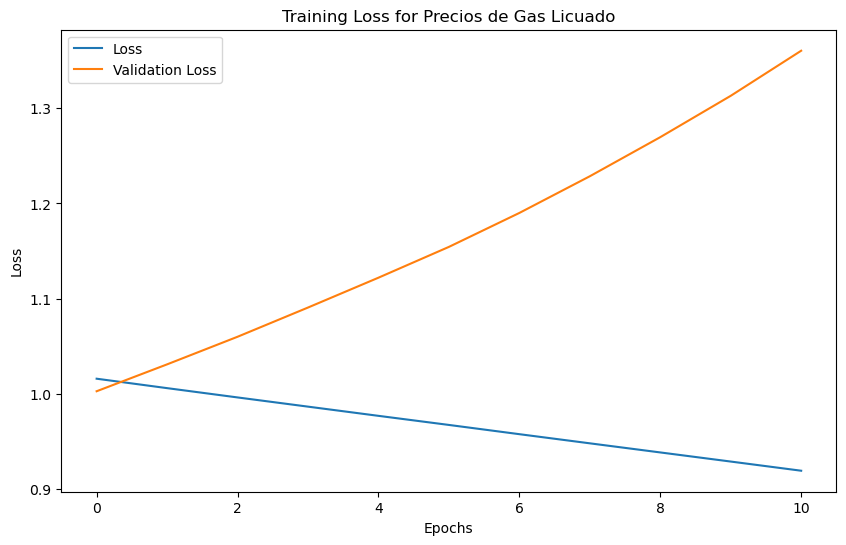

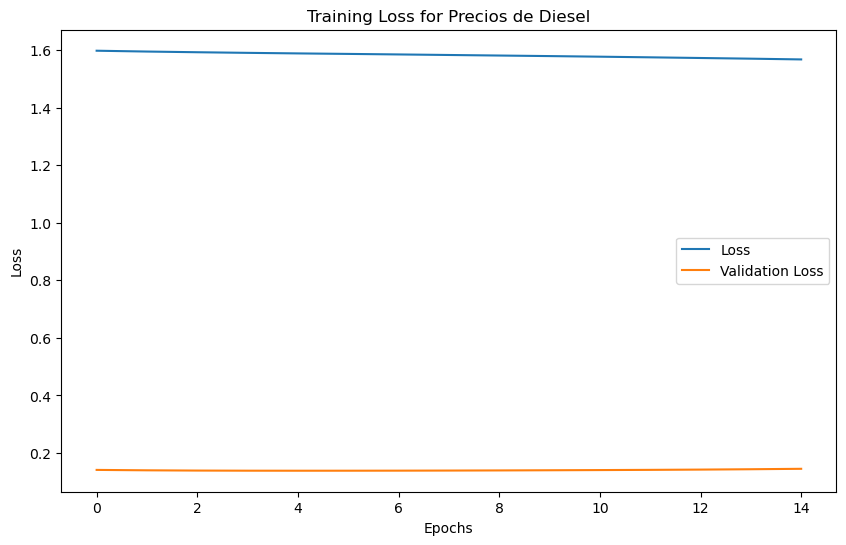

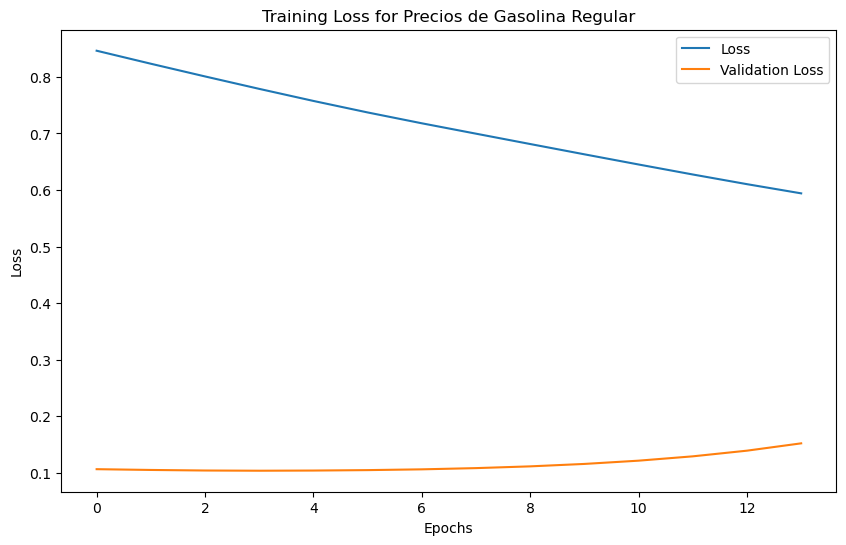

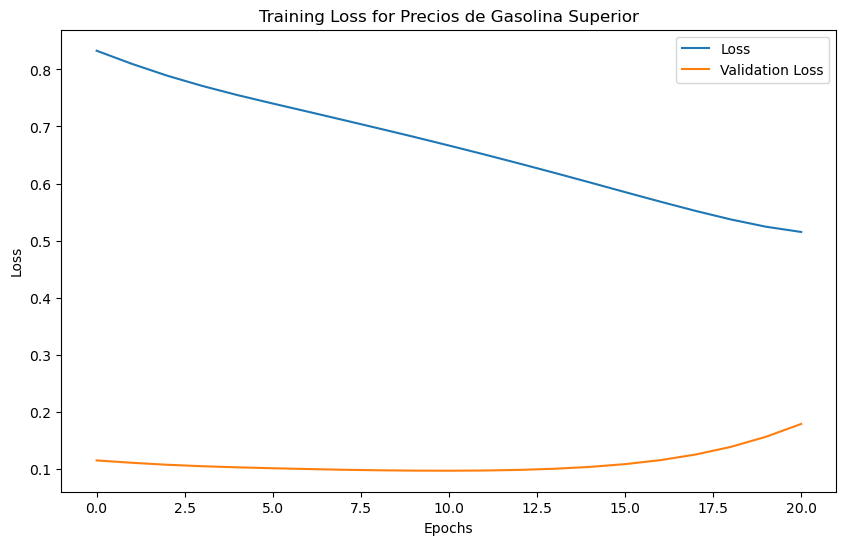

In [54]:
# Perdida Precios Gas Licuado
plt.figure(figsize=(10, 6))
plt.plot(history_precios_gas_licuado.history['loss'], label='Loss')
plt.plot(history_precios_gas_licuado.history['val_loss'], label='Validation Loss')
plt.title('Training Loss for Precios de Gas Licuado')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Perdida Precios Diesel
plt.figure(figsize=(10, 6))
plt.plot(history_precios_diesel.history['loss'], label='Loss')
plt.plot(history_precios_diesel.history['val_loss'], label='Validation Loss')
plt.title('Training Loss for Precios de Diesel')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Perdida Precios Regular
plt.figure(figsize=(10, 6))
plt.plot(history_precios_regular.history['loss'], label='Loss')
plt.plot(history_precios_regular.history['val_loss'], label='Validation Loss')
plt.title('Training Loss for Precios de Gasolina Regular')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Perdida Precios Superior
plt.figure(figsize=(10, 6))
plt.plot(history_precios_superior.history['loss'], label='Loss')
plt.plot(history_precios_superior.history['val_loss'], label='Validation Loss')
plt.title('Training Loss for Precios de Gasolina Superior')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Evaluacion del Modelo
Evaluamos el modelo utilizando la métrica de Root Mean Squared Error (RMSE).

In [55]:
# Evaluacion Gas Licuado
y_pred_precios_gas_licuado = model_precios_gas_licuado.predict(X_test_precios_gas_licuado)
rmse_precios_gas_licuado = np.sqrt(mean_squared_error(y_test_precios_gas_licuado, y_pred_precios_gas_licuado))
print(f'RMSE for Precios de Gas Licuado: {rmse_precios_gas_licuado}')
print()

# Evaluacion Diesel
y_pred_precios_diesel = model_precios_diesel.predict(X_test_precios_diesel)
rmse_precios_diesel = np.sqrt(mean_squared_error(y_test_precios_diesel, y_pred_precios_diesel))
print(f'RMSE for Precios de Diesel: {rmse_precios_diesel}')
print()

# Evaluacion Regular
y_pred_precios_regular = model_precios_regular.predict(X_test_precios_regular)
rmse_precios_regular = np.sqrt(mean_squared_error(y_test_precios_regular, y_pred_precios_regular))
print(f'RMSE for Precios de Gasolina Regular: {rmse_precios_regular}')
print()

# Evaluacion Superior
y_pred_precios_superior = model_precios_superior.predict(X_test_precios_superior)
rmse_precios_superior = np.sqrt(mean_squared_error(y_test_precios_superior, y_pred_precios_superior))
print(f'RMSE for Precios de Gasolina Superior: {rmse_precios_superior}')

1/1 [==============================] - 0s 379ms/step
RMSE for Precios de Gas Licuado: 1.0012454797385546

1/1 [==============================] - 0s 410ms/step
RMSE for Precios de Diesel: 0.3720491256332982

1/1 [==============================] - 2s 2s/step
RMSE for Precios de Gasolina Regular: 0.3223828291554725

1/1 [==============================] - 0s 428ms/step
RMSE for Precios de Gasolina Superior: 0.31104678665316576


#### Precios
Aplicar el Tuneo de Parámetros a la Serie de Precios

In [56]:
# Tuneo Gas Licuado
best_model_precios_gas_licuado = tune_lstm_model(X_train_precios_gas_licuado, y_train_precios_gas_licuado, X_test_precios_gas_licuado, y_test_precios_gas_licuado, [50, 100], [0.001, 0.0001])

Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 0.9897 - val_loss: 1.0474
Epoch 2/50
1/1 [==============================] - 0s 53ms/step - loss: 0.9800 - val_loss: 1.0820
Epoch 3/50
1/1 [==============================] - 0s 52ms/step - loss: 0.9700 - val_loss: 1.1205
Epoch 4/50
1/1 [==============================] - 0s 55ms/step - loss: 0.9597 - val_loss: 1.1631
Epoch 5/50
1/1 [==============================] - 0s 55ms/step - loss: 0.9491 - val_loss: 1.2098
Epoch 6/50
1/1 [==============================] - 0s 59ms/step - loss: 0.9382 - val_loss: 1.2594
Epoch 7/50
1/1 [==============================] - 0s 112ms/step - loss: 0.9272 - val_loss: 1.3133
Epoch 8/50
1/1 [==============================] - 0s 58ms/step - loss: 0.9162 - val_loss: 1.3722
Epoch 9/50
1/1 [==============================] - 0s 58ms/step - loss: 0.9050 - val_loss: 1.4367
Epoch 10/50
1/1 [==============================] - 0s 57ms/step - loss: 0.8936 - val_loss: 1.5068
Epoch 11/50
1/1 [=============

In [57]:
# Tuneo Diesel
best_model_precios_diesel = tune_lstm_model(X_train_precios_diesel, y_train_precios_diesel, X_test_precios_diesel, y_test_precios_diesel, [50, 100], [0.001, 0.0001])

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 1.5986 - val_loss: 0.1436
Epoch 2/50
1/1 [==============================] - 0s 58ms/step - loss: 1.5946 - val_loss: 0.1409
Epoch 3/50
1/1 [==============================] - 0s 57ms/step - loss: 1.5914 - val_loss: 0.1386
Epoch 4/50
1/1 [==============================] - 0s 59ms/step - loss: 1.5887 - val_loss: 0.1371
Epoch 5/50
1/1 [==============================] - 0s 61ms/step - loss: 1.5865 - val_loss: 0.1361
Epoch 6/50
1/1 [==============================] - 0s 57ms/step - loss: 1.5844 - val_loss: 0.1357
Epoch 7/50
1/1 [==============================] - 0s 60ms/step - loss: 1.5822 - val_loss: 0.1355
Epoch 8/50
1/1 [==============================] - 0s 60ms/step - loss: 1.5802 - val_loss: 0.1357
Epoch 9/50
1/1 [==============================] - 0s 60ms/step - loss: 1.5782 - val_loss: 0.1362
Epoch 10/50
1/1 [==============================] - 0s 58ms/step - loss: 1.5762 - val_loss: 0.1368
Epoch 11/50
1/1 [==============

In [58]:
# Tuneo Regular
best_model_precios_regular = tune_lstm_model(X_train_precios_regular, y_train_precios_regular, X_test_precios_regular, y_test_precios_regular, [50, 100], [0.001, 0.0001])

Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 0.8699 - val_loss: 0.1093
Epoch 2/50
1/1 [==============================] - 0s 74ms/step - loss: 0.8520 - val_loss: 0.1077
Epoch 3/50
1/1 [==============================] - 0s 183ms/step - loss: 0.8357 - val_loss: 0.1066
Epoch 4/50
1/1 [==============================] - 0s 84ms/step - loss: 0.8202 - val_loss: 0.1057
Epoch 5/50
1/1 [==============================] - 0s 69ms/step - loss: 0.8050 - val_loss: 0.1051
Epoch 6/50
1/1 [==============================] - 0s 67ms/step - loss: 0.7907 - val_loss: 0.1046
Epoch 7/50
1/1 [==============================] - 0s 64ms/step - loss: 0.7773 - val_loss: 0.1043
Epoch 8/50
1/1 [==============================] - 0s 75ms/step - loss: 0.7642 - val_loss: 0.1041
Epoch 9/50
1/1 [==============================] - 0s 75ms/step - loss: 0.7512 - val_loss: 0.1042
Epoch 10/50
1/1 [==============================] - 0s 73ms/step - loss: 0.7381 - val_loss: 0.1046
Epoch 11/50
1/1 [=============

In [59]:
# Tuneo Superior
best_model_precios_superior = tune_lstm_model(X_train_precios_superior, y_train_precios_superior, X_test_precios_superior, y_test_precios_superior, [50, 100], [0.001, 0.0001])

Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 0.8341 - val_loss: 0.1146
Epoch 2/50
1/1 [==============================] - 0s 63ms/step - loss: 0.8098 - val_loss: 0.1099
Epoch 3/50
1/1 [==============================] - 0s 68ms/step - loss: 0.7874 - val_loss: 0.1061
Epoch 4/50
1/1 [==============================] - 0s 63ms/step - loss: 0.7661 - val_loss: 0.1032
Epoch 5/50
1/1 [==============================] - 0s 59ms/step - loss: 0.7464 - val_loss: 0.1008
Epoch 6/50
1/1 [==============================] - 0s 57ms/step - loss: 0.7282 - val_loss: 0.0988
Epoch 7/50
1/1 [==============================] - 0s 60ms/step - loss: 0.7105 - val_loss: 0.0971
Epoch 8/50
1/1 [==============================] - 0s 61ms/step - loss: 0.6931 - val_loss: 0.0959
Epoch 9/50
1/1 [==============================] - 0s 65ms/step - loss: 0.6760 - val_loss: 0.0952
Epoch 10/50
1/1 [==============================] - 0s 66ms/step - loss: 0.6590 - val_loss: 0.0951
Epoch 11/50
1/1 [==============

## Evaluacion
Utilizamos el mejor modelo para hacer predicciones y calculamos el RMSE.

In [60]:
# Evaluacion modelo Gas Licuado
y_pred_best_precios_gas_licuado = best_model_precios_gas_licuado.predict(X_test_precios_gas_licuado)
best_rmse_precios_gas_licuado = np.sqrt(mean_squared_error(y_test_precios_gas_licuado, y_pred_best_precios_gas_licuado))
print(f'Best RMSE for Precios de Gas Licuado after tuning: {best_rmse_precios_gas_licuado}')
print()

# Evaluacion modelo Diesel
y_pred_best_precios_diesel = best_model_precios_diesel.predict(X_test_precios_diesel)
best_rmse_precios_diesel = np.sqrt(mean_squared_error(y_test_precios_diesel, y_pred_best_precios_diesel))
print(f'Best RMSE for Precios de Diesel after tuning: {best_rmse_precios_diesel}')  
print()

# Evaluacion modelo Regular
y_pred_best_precios_regular = best_model_precios_regular.predict(X_test_precios_regular)
best_rmse_precios_regular = np.sqrt(mean_squared_error(y_test_precios_regular, y_pred_best_precios_regular))
print(f'Best RMSE for Precios de Gasolina Regular after tuning: {best_rmse_precios_regular}')
print()

# Evaluacion modelo Superior
y_pred_best_precios_superior = best_model_precios_superior.predict(X_test_precios_superior) 
best_rmse_precios_superior = np.sqrt(mean_squared_error(y_test_precios_superior, y_pred_best_precios_superior))
print(f'Best RMSE for Precios de Gasolina Superior after tuning: {best_rmse_precios_superior}') 

1/1 [==============================] - 0s 22ms/step
Best RMSE for Precios de Gas Licuado after tuning: 1.0128057401690407

1/1 [==============================] - 0s 32ms/step
Best RMSE for Precios de Diesel after tuning: 0.36516940134960885

1/1 [==============================] - 0s 33ms/step
Best RMSE for Precios de Gasolina Regular after tuning: 0.32267179387880335

1/1 [==============================] - 0s 35ms/step
Best RMSE for Precios de Gasolina Superior after tuning: 0.30808678638558007


### Guardar Modelo para la Serie Precios

In [62]:
# Guardar los modelos
best_model_precios_gas_licuado.save('BestModels/PRECIOS-M1/best_model_precios_gas_licuado.h5')
best_model_precios_diesel.save('BestModels/PRECIOS-M1/best_model_precios_diesel.h5')
best_model_precios_regular.save('BestModels/PRECIOS-M1/best_model_precios_regular.h5')
best_model_precios_superior.save('BestModels/PRECIOS-M1/best_model_precios_superior.h5')  

## Modelo LSTM #2 para la serie PRECIOS
Definimos una función para crear un modelo LSTM con una arquitectura básica.... AQUI EMPEZAR EL MODELO 2